# Parte 1: Importación de todas las librerías necesarias

In [1]:
# Parte 1: Importación de todas las librerías necesarias

# Instalación de paquetes necesarios
#!pip install lazypredict
#!pip install optuna
#!pip install h2o

# Bibliotecas básicas
import pandas as pd
import numpy as np
import pickle
import time
import warnings

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y transformación
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA

# Selección de modelos y validación
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold,
    ParameterSampler, cross_val_score, RepeatedStratifiedKFold
)

# Métricas y evaluación
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

# Modelos
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier

# Otras utilidades
from scipy.cluster import hierarchy
from lazypredict.Supervised import LazyClassifier
from tqdm.notebook import tqdm  # Para barras de progreso en notebook
import optuna
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

# Parte 2: Carga de datos

In [2]:
# Carga de datos desde GitHub
train_values_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_values.csv"
train_labels_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_labels.csv"
test_values_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/test_values.csv"

# Cargar los datasets
train_values = pd.read_csv(train_values_url)
train_labels = pd.read_csv(train_labels_url)
test_values = pd.read_csv(test_values_url)

# Mostrar dimensiones de los datasets
print("Dimensiones del conjunto de datos de entrenamiento (features):", train_values.shape)
print("Dimensiones del conjunto de datos de entrenamiento (labels):", train_labels.shape)
print("Dimensiones del conjunto de datos de prueba:", test_values.shape)

# Verificar los primeros registros
train_values.head()

Dimensiones del conjunto de datos de entrenamiento (features): (260601, 39)
Dimensiones del conjunto de datos de entrenamiento (labels): (260601, 2)
Dimensiones del conjunto de datos de prueba: (86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


# Parte 3: Análisis Exploratorio de Datos (EDA)

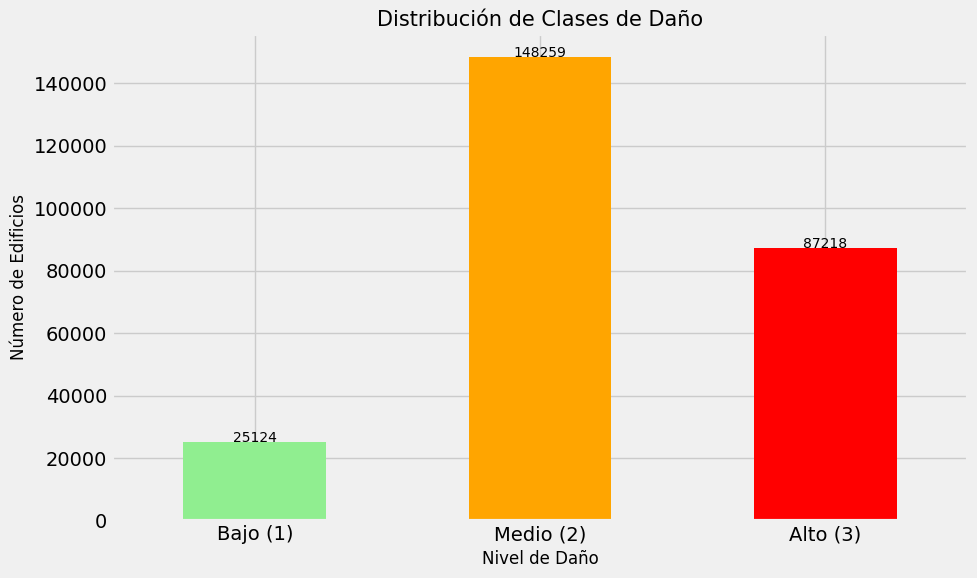

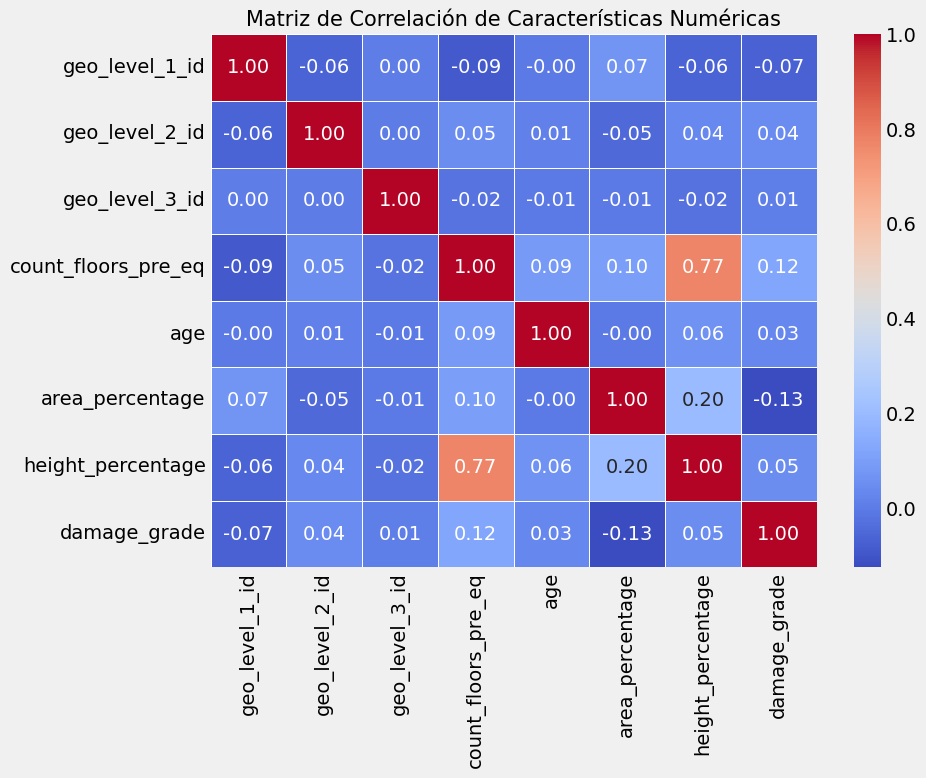

Se identificaron 22 columnas binarias


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,13.90,701.07,6257.88,2.13,26.54,8.02,5.43
std,8.03,412.71,3646.37,0.73,73.57,4.39,1.92
min,0.00,0.00,0.00,1.00,0.00,1.00,2.00
25%,7.00,350.00,3073.00,2.00,10.00,5.00,4.00
50%,12.00,702.00,6270.00,2.00,15.00,7.00,5.00
75%,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00
max,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00


In [3]:
# Fusionar datos de entrenamiento y etiquetas para el análisis
train_data = pd.merge(train_values, train_labels, on="building_id")

# Explorar distribución de la variable objetivo
plt.figure(figsize=(10, 6))
damage_counts = train_data['damage_grade'].value_counts().sort_index()
ax = damage_counts.plot(kind='bar', color=['lightgreen', 'orange', 'red'])
plt.title('Distribución de Clases de Daño', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Bajo (1)', 'Medio (2)', 'Alto (3)'], rotation=0)

# Agregar valores sobre las barras
for i, v in enumerate(damage_counts):
    ax.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Explorar características numéricas
numerical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq',
                      'age', 'area_percentage', 'height_percentage']

# Matriz de correlación de características numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = train_data[numerical_features + ['damage_grade']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Características Numéricas', fontsize=15)
plt.tight_layout()
plt.show()

# Análisis de características categóricas
categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type',
                       'ground_floor_type', 'other_floor_type']


# Identificar columnas binarias (codificadas como 0-1)
binary_columns = []
for col in train_values.columns:
    unique_vals = train_values[col].unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        binary_columns.append(col)

print(f"Se identificaron {len(binary_columns)} columnas binarias")

# Resumen estadístico de características numéricas importantes
train_data[numerical_features].describe()

# Parte 3.5: Caracteristicas Dendograma

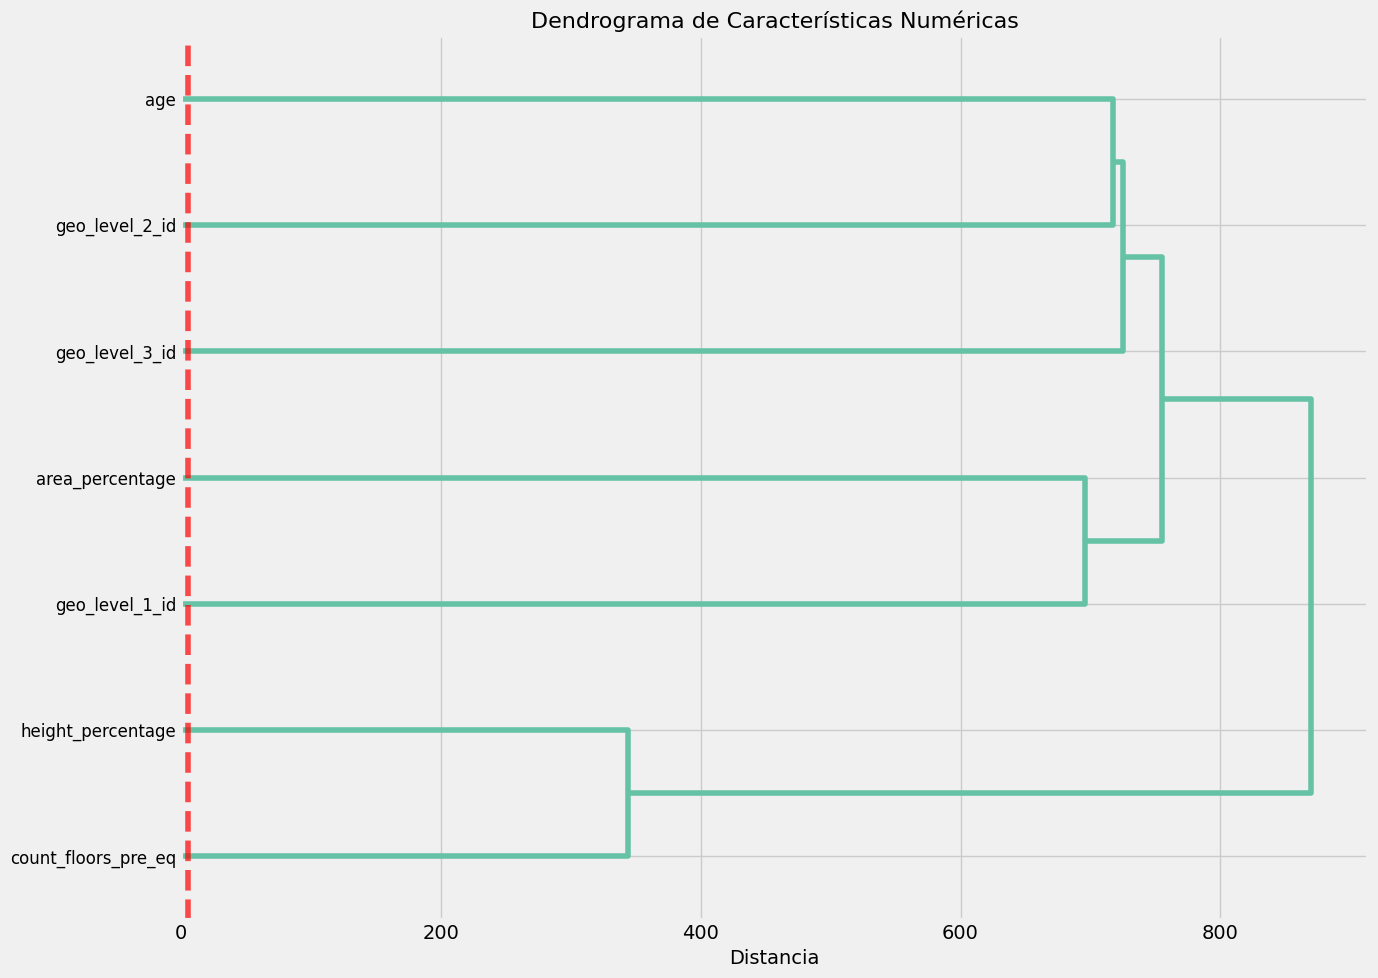

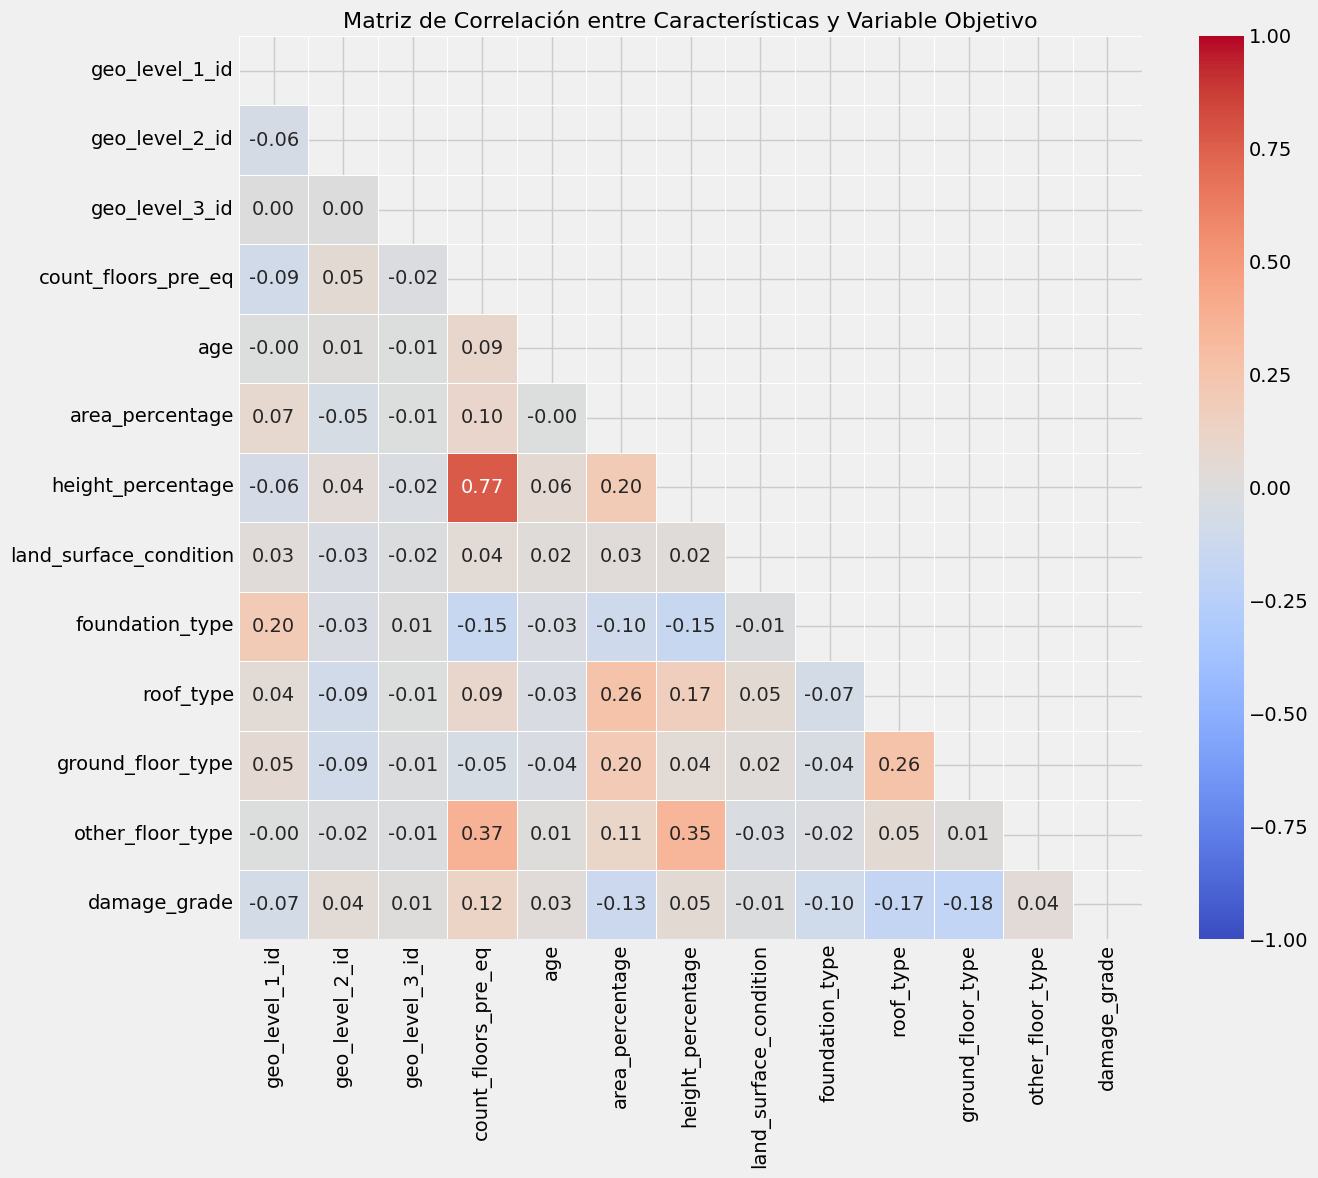

Características seleccionadas para modelado: ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered']


In [4]:
# Preparación de datos para dendrograma
# Seleccionamos características numéricas
X_numerical = train_data[numerical_features].copy()

# Escalamos los datos para el dendrograma
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Creamos el dendrograma
plt.figure(figsize=(14, 10))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_scaled.T, method='ward'),  # Transpuesta para clustering de características
    labels=X_numerical.columns,
    orientation='right',
    leaf_font_size=12,
    color_threshold=5
)
plt.title('Dendrograma de Características Numéricas', fontsize=16)
plt.xlabel('Distancia', fontsize=14)
plt.axvline(x=5, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Análisis de correlación entre características categóricas y numéricas
# Para esto, convertiremos las categóricas a numéricas temporalmente

# Función para convertir características categóricas a numéricas
def convert_categorical_to_numeric(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    return df_encoded

categorical_cols = [col for col in train_data.columns
                   if train_data[col].dtype == 'object' and col not in ['building_id']]

train_data_encoded = convert_categorical_to_numeric(train_data, categorical_cols)

# Seleccionamos un subset de columnas para el heatmap (para evitar sobrecarga visual)
selected_features = numerical_features + categorical_cols[:5]  # Primeras 5 categóricas
selected_features.append('damage_grade')  # Añadir variable objetivo

plt.figure(figsize=(14, 12))
correlation = train_data_encoded[selected_features].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Características y Variable Objetivo', fontsize=16)
plt.tight_layout()
plt.show()

# Basado en el dendrograma y la correlación, seleccionamos las características relevantes
selected_features = [
    'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
    'land_surface_condition', 'foundation_type', 'roof_type',
    'ground_floor_type', 'other_floor_type'
]

# Podemos añadir algunas características adicionales basadas en el dominio
selected_features += [col for col in binary_columns[:10]]  # Añadir primeras 10 columnas binarias

print("Características seleccionadas para modelado:", selected_features)

# Parte 3.5-2: Selección características

===== SELECCIÓN DE CARACTERÍSTICAS =====

--- Selección basada en prueba F (ANOVA) ---
Top 20 características según prueba F:


,Característica,Puntuación F,P-valor
38,damage_grade,inf,0.00
15,has_superstructure_mud_mortar_stone,16490.39,0.00
19,has_superstructure_cement_mortar_brick,11120.19,0.00
23,has_superstructure_rc_engineered,7757.59,0.00
9,roof_type,6944.70,0.00
10,ground_floor_type,5750.58,0.00
22,has_superstructure_rc_non_engineered,4721.92,0.00
0,geo_level_1_id,2657.79,0.00
3,count_floors_pre_eq,2544.84,0.00
5,area_percentage,2529.05,0.00


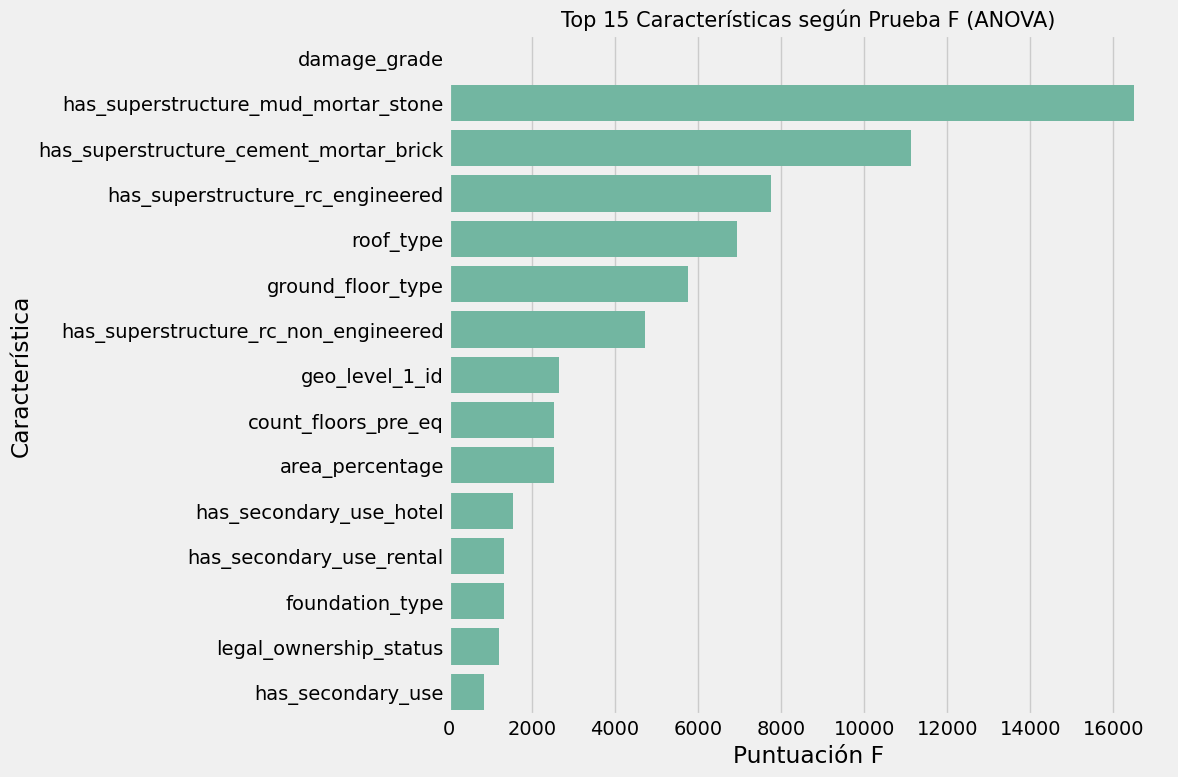


--- Selección basada en Información Mutua ---
Top 20 características según Información Mutua:


,Característica,Información Mutua
38,damage_grade,0.94
2,geo_level_3_id,0.30
1,geo_level_2_id,0.23
0,geo_level_1_id,0.13
8,foundation_type,0.09
15,has_superstructure_mud_mortar_stone,0.07
11,other_floor_type,0.06
10,ground_floor_type,0.06
9,roof_type,0.04
3,count_floors_pre_eq,0.03


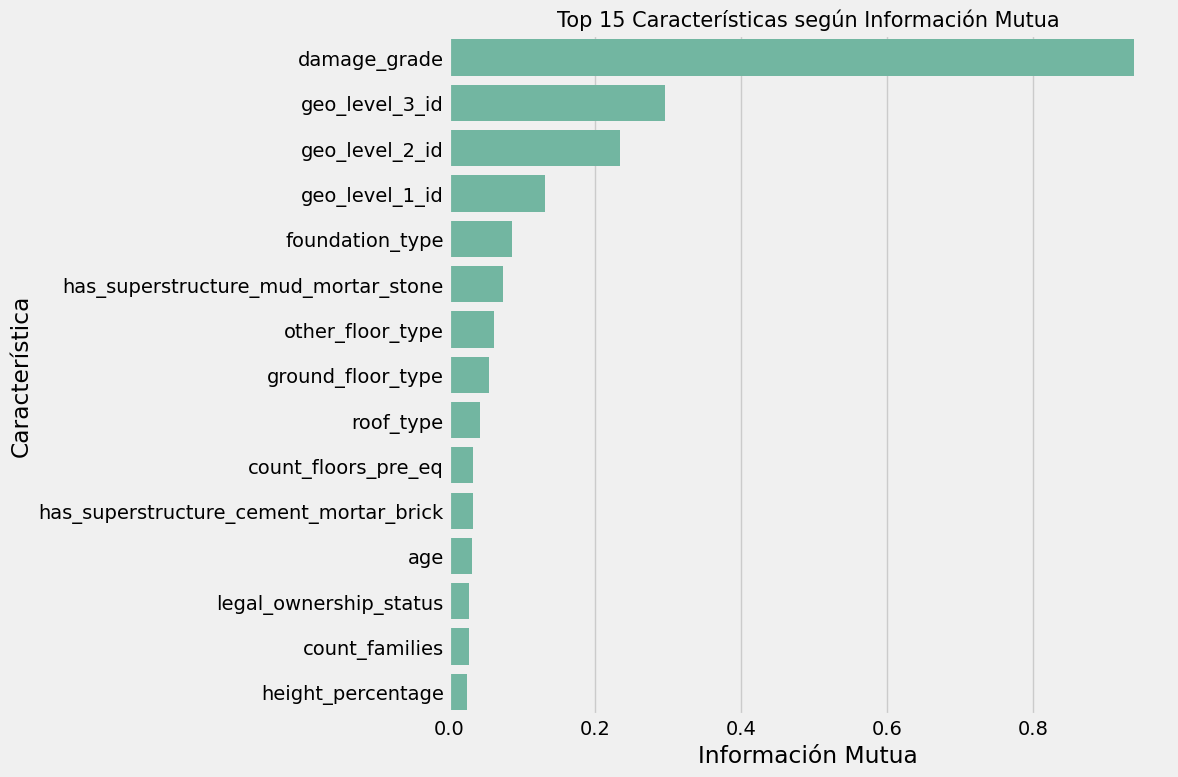


--- Selección basada en Importancia de Características (RandomForest) ---
Top 20 características según RandomForest:


,Característica,Importancia
38,damage_grade,0.88
0,geo_level_1_id,0.02
8,foundation_type,0.01
15,has_superstructure_mud_mortar_stone,0.01
9,roof_type,0.01
1,geo_level_2_id,0.01
4,age,0.01
10,ground_floor_type,0.01
2,geo_level_3_id,0.01
19,has_superstructure_cement_mortar_brick,0.01


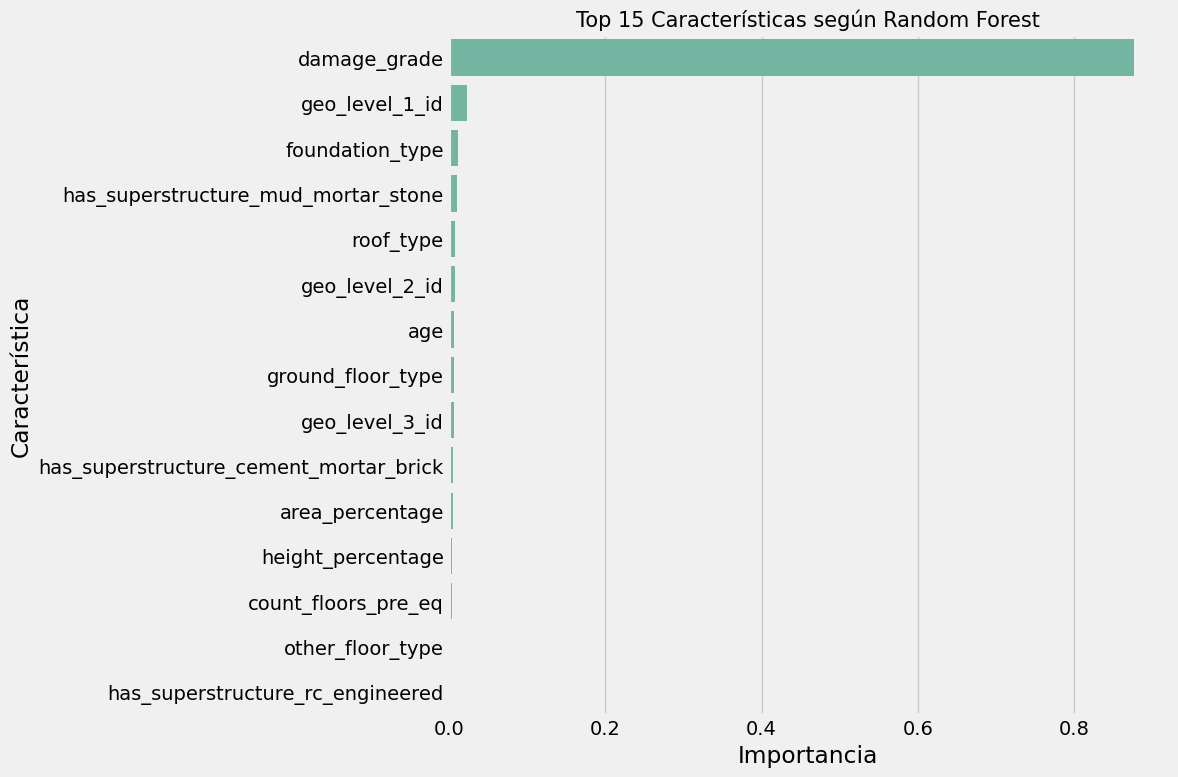


Características seleccionadas automáticamente por RandomForest (threshold='mean'): 1
['damage_grade']

--- Análisis de Componentes Principales ---
Número de componentes necesarios para explicar 95% de la varianza: 34


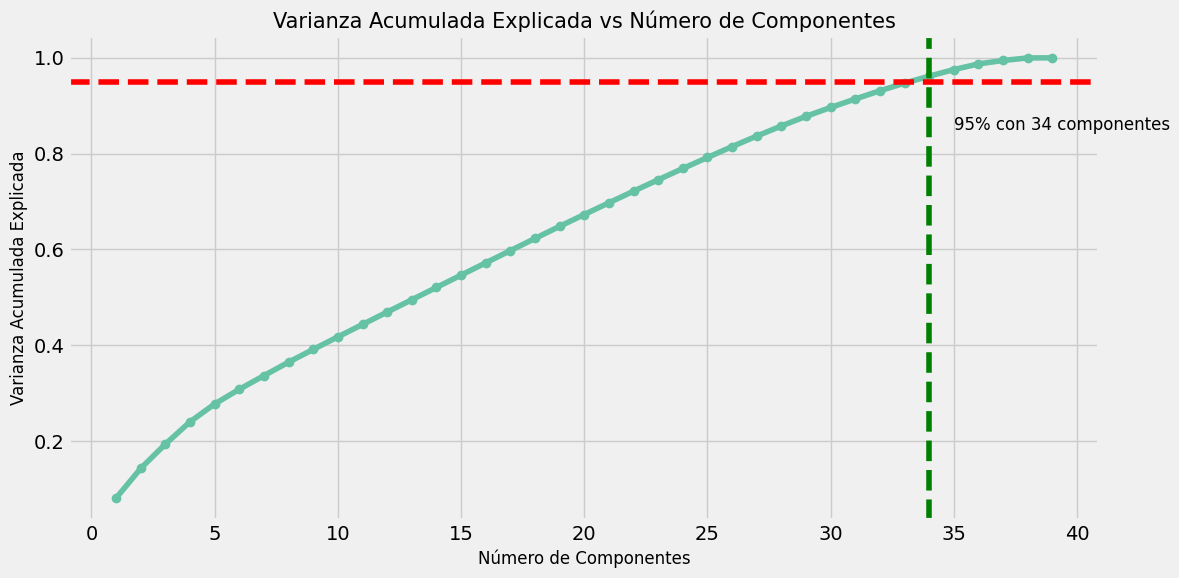


--- Características comunes entre métodos de selección ---
Características comunes en ANOVA y MI: 11
Características comunes en ANOVA y RF: 13
Características comunes en MI y RF: 17
Características comunes en los tres métodos: 10
Características comunes en los tres métodos:
['area_percentage', 'count_floors_pre_eq', 'damage_grade', 'foundation_type', 'geo_level_1_id', 'ground_floor_type', 'has_superstructure_cement_mortar_brick', 'has_superstructure_mud_mortar_stone', 'has_superstructure_rc_engineered', 'roof_type']

--- Selección final de características ---
Total de características seleccionadas: 21
Lista final de características seleccionadas:
['age', 'area_percentage', 'count_families', 'count_floors_pre_eq', 'damage_grade', 'foundation_type', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'ground_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_cement_mortar_brick', 'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone', 'has_superstru

In [5]:
print("===== SELECCIÓN DE CARACTERÍSTICAS =====")

# 1. Preparación de datos para selección de características
# Convertimos características categóricas a numéricas para análisis estadísticos
X_encoded = convert_categorical_to_numeric(train_data, categorical_cols)
X_encoded = X_encoded.drop(['building_id'], axis=1)
y = train_data['damage_grade']

# 2. Método 1: Análisis univariante usando prueba F (ANOVA F-test)
print("\n--- Selección basada en prueba F (ANOVA) ---")
k_best_features = 20  # Seleccionamos top 20 características
selector_f = SelectKBest(f_classif, k=k_best_features)
X_kbest = selector_f.fit_transform(X_encoded, y)

# Obtener puntuaciones y nombres de las características seleccionadas
feature_scores = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Puntuación F': selector_f.scores_,
    'P-valor': selector_f.pvalues_
})

# Ordenar por puntuación descendente y mostrar top 20
top_features_f = feature_scores.sort_values('Puntuación F', ascending=False).head(20)
print("Top 20 características según prueba F:")
display(top_features_f)

# Visualización de las principales características según ANOVA
plt.figure(figsize=(12, 8))
sns.barplot(x='Puntuación F', y='Característica', data=top_features_f.head(15))
plt.title('Top 15 Características según Prueba F (ANOVA)', fontsize=15)
plt.tight_layout()
plt.show()

# 3. Método 2: Información Mutua (captura relaciones no lineales)
print("\n--- Selección basada en Información Mutua ---")
selector_mi = SelectKBest(mutual_info_classif, k=k_best_features)
X_mi = selector_mi.fit_transform(X_encoded, y)

# Obtener puntuaciones
feature_scores_mi = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Información Mutua': selector_mi.scores_
})

# Ordenar por puntuación descendente y mostrar top 20
top_features_mi = feature_scores_mi.sort_values('Información Mutua', ascending=False).head(20)
print("Top 20 características según Información Mutua:")
display(top_features_mi)

# Visualización de las principales características según Información Mutua
plt.figure(figsize=(12, 8))
sns.barplot(x='Información Mutua', y='Característica', data=top_features_mi.head(15))
plt.title('Top 15 Características según Información Mutua', fontsize=15)
plt.tight_layout()
plt.show()

# 4. Método 3: Importancia de características con RandomForest
print("\n--- Selección basada en Importancia de Características (RandomForest) ---")
feature_selector_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
feature_selector_rf.fit(X_encoded, y)

# Obtener importancias
feature_importances = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Importancia': feature_selector_rf.feature_importances_
})

# Ordenar por importancia descendente y mostrar top 20
top_features_rf = feature_importances.sort_values('Importancia', ascending=False).head(20)
print("Top 20 características según RandomForest:")
display(top_features_rf)

# Visualización de las principales características según RandomForest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Característica', data=top_features_rf.head(15))
plt.title('Top 15 Características según Random Forest', fontsize=15)
plt.tight_layout()
plt.show()

# 5. Selección automática de características basada en umbral de importancia
selector_model = SelectFromModel(feature_selector_rf, threshold='mean')
X_important = selector_model.fit_transform(X_encoded, y)
selected_features_mask = selector_model.get_support()
selected_features = X_encoded.columns[selected_features_mask]

print(f"\nCaracterísticas seleccionadas automáticamente por RandomForest (threshold='mean'): {len(selected_features)}")
print(sorted(selected_features))

# 6. Análisis de Componentes Principales (PCA)
print("\n--- Análisis de Componentes Principales ---")
pca = PCA()
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_encoded))

# Varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Determinar número de componentes para explicar al menos 95% de la varianza
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Número de componentes necesarios para explicar 95% de la varianza: {n_components_95}")

# Visualización de la varianza explicada
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.text(n_components_95+1, 0.85, f'95% con {n_components_95} componentes', fontsize=12)
plt.title('Varianza Acumulada Explicada vs Número de Componentes', fontsize=15)
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada Explicada', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Análisis final y compilación de selección de características

# Características que aparecen en al menos dos métodos (ANOVA, MI, RF)
common_features_anova_mi = set(top_features_f['Característica']).intersection(set(top_features_mi['Característica']))
common_features_anova_rf = set(top_features_f['Característica']).intersection(set(top_features_rf['Característica']))
common_features_mi_rf = set(top_features_mi['Característica']).intersection(set(top_features_rf['Característica']))

# Características que aparecen en los tres métodos
common_features_all = common_features_anova_mi.intersection(set(top_features_rf['Característica']))

print("\n--- Características comunes entre métodos de selección ---")
print(f"Características comunes en ANOVA y MI: {len(common_features_anova_mi)}")
print(f"Características comunes en ANOVA y RF: {len(common_features_anova_rf)}")
print(f"Características comunes en MI y RF: {len(common_features_mi_rf)}")
print(f"Características comunes en los tres métodos: {len(common_features_all)}")
print("Características comunes en los tres métodos:")
print(sorted(common_features_all))

# 8. Selección final de características basada en múltiples métodos

# Combinamos las características seleccionadas por diferentes métodos
# Incluimos todas las que aparecen en al menos dos métodos más las sugeridas por el dendrograma
selected_features_from_dendogram = selected_features  # Las que ya teníamos del dendrograma
selected_features_from_statistical = list(common_features_anova_mi.union(common_features_anova_rf, common_features_mi_rf))

# Características finales
final_selected_features = list(set(selected_features_from_dendogram).union(set(selected_features_from_statistical)))

print("\n--- Selección final de características ---")
print(f"Total de características seleccionadas: {len(final_selected_features)}")
print("Lista final de características seleccionadas:")
print(sorted(final_selected_features))

# Actualizar la lista de características seleccionadas para el modelado
selected_features = final_selected_features

# Parte 4: Preparación de datos para modelado

Estrategia de selección de muestra:
- Realizaremos un muestreo estratificado para mantener la distribución de clases
- Utilizaremos una selección basada en características geográficas para diversificar la muestra
- Seleccionaremos edificios con diferentes características estructurales
Muestra final: 19879 edificios


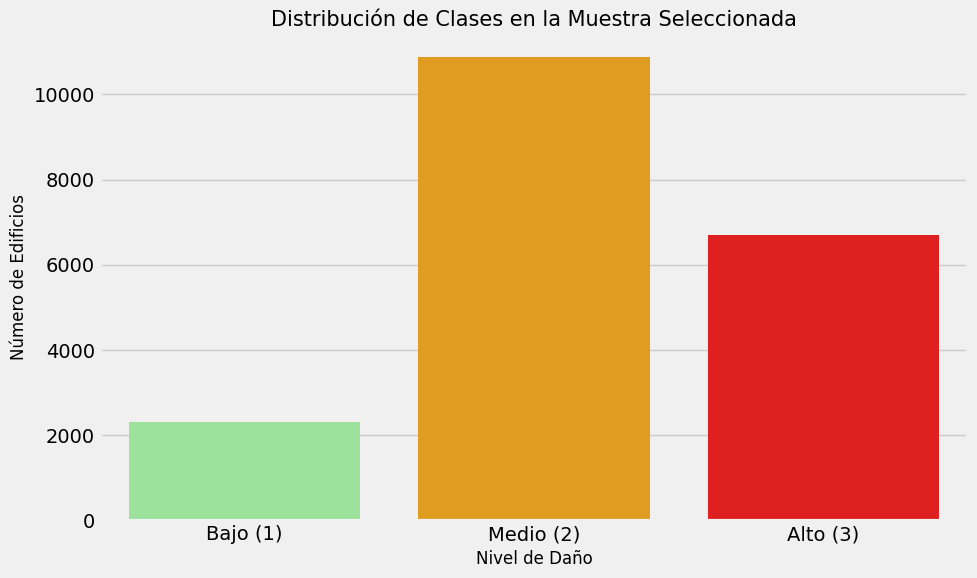

Tamaño conjunto entrenamiento: 15903 muestras
Tamaño conjunto prueba: 3976 muestras


In [6]:
# Preprocesamiento de datos
X = train_data.drop(['building_id', 'damage_grade'], axis=1)
y = train_data['damage_grade']

# Identificar tipos de características
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Justificación para la selección de la muestra
print("Estrategia de selección de muestra:")
print("- Realizaremos un muestreo estratificado para mantener la distribución de clases")
print("- Utilizaremos una selección basada en características geográficas para diversificar la muestra")
print("- Seleccionaremos edificios con diferentes características estructurales")

# Selección de muestra justificada (no aleatoria)
# Agrupamos por niveles geográficos y tomamos un subconjunto representativo

def advanced_sampling(df, y, sample_size=20000):
    """
    Función para realizar un muestreo estratificado pero determinístico
    basado en características importantes del dominio
    """
    # Aseguramos que tengamos representación de diferentes regiones geográficas
    geo_groups = df.groupby(['geo_level_1_id', 'geo_level_2_id'])

    # Inicializar el DataFrame para la muestra
    sampled_indices = []

    # Para cada grupo geográfico, seleccionamos ejemplos representativos
    for name, group in geo_groups:
        # Determinamos cuántas muestras tomar de este grupo (proporcional a su tamaño)
        group_size = len(group)
        group_sample_size = max(1, int(group_size / len(df) * sample_size))

        # Estratificamos por nivel de daño dentro de cada grupo geográfico
        for damage_level in [1, 2, 3]:
            damage_indices = group[y == damage_level].index
            if len(damage_indices) > 0:
                # Tomamos un número proporcional de cada nivel de daño
                damage_ratio = sum(y[group.index] == damage_level) / group_size
                damage_sample_size = max(1, int(group_sample_size * damage_ratio))

                # Seleccionamos índices de forma determinística (no aleatoria)
                # Usamos características como edad y número de pisos para ordenar
                sorted_indices = df.loc[damage_indices].sort_values(
                    by=['age', 'count_floors_pre_eq', 'area_percentage']
                ).index[:damage_sample_size]

                sampled_indices.extend(sorted_indices)

    # Si no alcanzamos el tamaño deseado, completamos con más muestras
    if len(sampled_indices) < sample_size:
        remaining = sample_size - len(sampled_indices)
        # Seleccionamos más edificios basados en otras características
        additional_indices = df.sort_values(
            by=['foundation_type', 'roof_type', 'height_percentage']
        ).index[:remaining]
        sampled_indices.extend([idx for idx in additional_indices if idx not in sampled_indices])

    # Limitamos al tamaño deseado
    sampled_indices = sampled_indices[:sample_size]

    print(f"Muestra final: {len(sampled_indices)} edificios")

    return df.loc[sampled_indices], y.loc[sampled_indices]

# Seleccionamos un subconjunto manejable de datos
X_sampled, y_sampled = advanced_sampling(X, y, sample_size=20000)

# Verificamos la distribución de clases en la muestra
plt.figure(figsize=(10, 6))
sns.countplot(x=y_sampled, palette=['lightgreen', 'orange', 'red'])
plt.title('Distribución de Clases en la Muestra Seleccionada', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks([0, 1, 2], ['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.tight_layout()
plt.show()

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño conjunto prueba: {X_test.shape[0]} muestras")

# Definimos el preprocesador para manejar columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Preprocesamos los datos
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Guardamos el preprocesador para usarlo más tarde con los datos de prueba
import pickle
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# Parte 5: Uso de LazyPredict para buscar modelos

In [29]:
# Ejecutamos LazyPredict para comparar múltiples modelos rápidamente
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

# Mostramos los resultados de todos los modelos
print("Comparación de modelos con LazyPredict:")
display(models)

# Visualización de los resultados
plt.figure(figsize=(12, 8))
models_accuracy = models.sort_values(by='Accuracy', ascending=False)[:15]
sns.barplot(x=models_accuracy.index, y=models_accuracy['Accuracy'], palette='viridis')
plt.title('Top 15 Modelos por Precisión (Accuracy)', fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Precisión', fontsize=12)
plt.tight_layout()
plt.show()

# También analizamos el F1-score, que es nuestra métrica principal
plt.figure(figsize=(12, 8))
models_f1 = models.sort_values(by='F1 Score', ascending=False)[:15]
sns.barplot(x=models_f1.index, y=models_f1['F1 Score'], palette='plasma')
plt.title('Top 15 Modelos por F1-Score', fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('F1-Score', fontsize=12)
plt.tight_layout()
plt.show()

# Parte 6: Evaluación de modelos seleccionados

In [ ]:
# Lista de modelos a evaluar
models_to_evaluate = {
    'LGBM': LGBMClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10), random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

# Validación cruzada con datos ya preprocesados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("\nRealizando validación cruzada con datos preprocesados:")

# Convertir a array numpy si es sparse matrix para evitar problemas con LGBM
if hasattr(X_train_processed, 'toarray'):
    X_train_array = X_train_processed.toarray()
else:
    X_train_array = X_train_processed

# Validación cruzada para cada modelo
for name, model in models_to_evaluate.items():
    scores = []
    
    # Para SVC, podemos limitar el tamaño si los datos son muy grandes
    if name == 'SVC' and X_train_array.shape[0] > 5000:
        # Usar una muestra más pequeña solo para SVC
        indices = np.random.choice(X_train_array.shape[0], 5000, replace=False)
        X_svc = X_train_array[indices]
        y_svc = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]
        
        # Validación cruzada para SVC con muestra reducida
        for train_idx, val_idx in cv.split(X_svc, y_svc):
            X_fold_train = X_svc[train_idx]
            X_fold_val = X_svc[val_idx]
            y_fold_train = y_svc.iloc[train_idx] if isinstance(y_svc, pd.Series) else y_svc[train_idx]
            y_fold_val = y_svc.iloc[val_idx] if isinstance(y_svc, pd.Series) else y_svc[val_idx]
            
            # Entrenar y evaluar
            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
            fold_score = f1_score(y_fold_val, y_pred, average='micro')
            scores.append(fold_score)
    else:
        # Validación cruzada normal para otros modelos
        for train_idx, val_idx in cv.split(X_train_array, y_train):
            X_fold_train = X_train_array[train_idx]
            X_fold_val = X_train_array[val_idx]
            y_fold_train = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
            y_fold_val = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]
            
            # Entrenar y evaluar
            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
            fold_score = f1_score(y_fold_val, y_pred, average='micro')
            scores.append(fold_score)
    
    # Calcular y guardar métricas
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_results[name] = (mean_score, std_score)
    print(f"{name}: F1-Micro = {mean_score:.4f} ± {std_score:.4f}")

# =====================================================================
# VISUALIZACIÓN Y ANÁLISIS DE RESULTADOS
# =====================================================================

# 3.1 Gráfico de barras para comparación de F1-score
plt.figure(figsize=(10, 6))
models_name = list(cv_results.keys())
cv_mean = [cv_results[model][0] for model in models_name]
cv_std = [cv_results[model][1] for model in models_name]

bars = plt.bar(models_name, cv_mean, yerr=cv_std, capsize=10, 
              color=['#5cb85c', '#5bc0de', '#f0ad4e', '#d9534f'])
plt.title('Comparación de Modelos (F1-Micro)', fontsize=15)
plt.ylabel('Puntuación F1-Micro')
plt.ylim(0.5, 1.0)  # Ajustar según tus resultados

# Añadir valores sobre las barras
for bar, score in zip(bars, cv_mean):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# 3.2 Tabla de resultados
print("\nTabla de resultados de validación cruzada:")
results_table = pd.DataFrame({
    'Modelo': models_name,
    'F1-Micro': [f"{cv_results[model][0]:.4f}" for model in models_name],
    'Desv. Estándar': [f"{cv_results[model][1]:.4f}" for model in models_name]
})
print(results_table)

# Identificar el mejor modelo
best_score = 0
best_model_name = None

for name, (mean, std) in cv_results.items():
    if mean > best_score:
        best_score = mean
        best_model_name = name

print(f"\nMejor modelo identificado: {best_model_name} con F1-Micro = {best_score:.4f}")
# Guardar los resultados para futuro uso
results_table.to_csv('model_comparison_results.csv', index=False)
print("\nResultados guardados en 'model_comparison_results.csv'")

# Parte 7: Implementación de GridSearchCV y RandomizedSearchCV

In [40]:
print("\nOptimización de hiperparámetros exclusivamente para LGBM...")
# =====================================================================
# PASO 1: VERIFICAR Y PREPARAR LOS DATOS
# =====================================================================
print("\nVerificando datos preprocesados...")

# Asegurarse de que estamos usando los datos ya preprocesados
if 'X_train_processed' in locals() or 'X_train_processed' in globals():
    print("✓ Usando datos preprocesados existentes")
    # Convertir a array numpy denso si es una matriz sparse
    if hasattr(X_train_processed, 'toarray'):
        X_train_final = X_train_processed.toarray()
    else:
        X_train_final = X_train_processed
    
    if hasattr(X_test_processed, 'toarray'):
        X_test_final = X_test_processed.toarray()
    else:
        X_test_final = X_test_processed
        
    y_train_final = y_train
    y_test_final = y_test
else:
    print("⚠️ Datos preprocesados no encontrados.")
    print("Aplicando preprocesamiento...")
    # Aplicar preprocesamiento si no se ha hecho
    X_train_final = preprocessor.transform(X_train)
    X_test_final = preprocessor.transform(X_test)
    
    # Convertir a array denso si es necesario
    if hasattr(X_train_final, 'toarray'):
        X_train_final = X_train_final.toarray()
        X_test_final = X_test_final.toarray()
    
    y_train_final = y_train
    y_test_final = y_test

print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

# =====================================================================
# PASO 2: CONFIGURAR HIPERPARÁMETROS PARA LGBM
# =====================================================================
print("\nConfigurando espacio de hiperparámetros para LGBM...")

# Parámetros para LGBM
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 9, 11],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}
base_params = {'random_state': 42, 'n_jobs': -1, 'verbose': -1}

# =====================================================================
# PASO 3: EJECUTAR GRIDSEARCHCV
# =====================================================================
print("\nEjecutando GridSearchCV para LGBM...")
start_time = time.time()

# Definir modelo base
base_model = LGBMClassifier(**base_params)

# Configurar GridSearchCV con menos combinaciones para que sea más rápido
grid = GridSearchCV(
    base_model,
    param_grid,
    cv=3,
    scoring='f1_micro',
    n_jobs=-1,
    verbose=1
)

# Ejecutar GridSearchCV
grid.fit(X_train_final, y_train_final)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTiempo de ejecución de GridSearchCV: {elapsed_time:.2f} segundos")

print(f"\nMejores parámetros con GridSearchCV:")
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Mejor F1-Micro: {grid.best_score_:.4f}")

# =====================================================================
# PASO 4: EJECUTAR RANDOMIZEDSEARCHCV
# =====================================================================
print("\nEjecutando RandomizedSearchCV para LGBM...")
start_time = time.time()

# Configurar espacio de parámetros más amplio para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, -1],
    'num_leaves': [31, 63, 127, 255],
    'min_child_samples': [5, 10, 15, 20, 25, 30],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.03, 0.1, 0.3],
    'reg_lambda': [0, 0.01, 0.03, 0.1, 0.3]
}

# Generar combinaciones de parámetros
random_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=15,  # Más iteraciones para explorar mejor el espacio
    cv=3,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Ejecutar RandomizedSearchCV
random_search.fit(X_train_final, y_train_final)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTiempo de ejecución de RandomizedSearchCV: {elapsed_time:.2f} segundos")

print(f"\nMejores parámetros con RandomizedSearchCV:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Mejor F1-Micro: {random_search.best_score_:.4f}")

# =====================================================================
# PASO 5: EVALUAR EN CONJUNTO DE PRUEBA
# =====================================================================
print("\nEvaluando modelos en conjunto de prueba...")

# Evaluar GridSearchCV
grid_model = grid.best_estimator_
grid_pred = grid_model.predict(X_test_final)
grid_f1 = f1_score(y_test_final, grid_pred, average='micro')
print(f"F1-Micro en conjunto de prueba para GridSearchCV: {grid_f1:.4f}")

# Evaluar RandomizedSearchCV
random_model = random_search.best_estimator_
random_pred = random_model.predict(X_test_final)
random_f1 = f1_score(y_test_final, random_pred, average='micro')
print(f"F1-Micro en conjunto de prueba para RandomizedSearchCV: {random_f1:.4f}")

# =====================================================================
# PASO 6: VISUALIZAR RESULTADOS
# =====================================================================
# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de confusión para GridSearchCV
cm_grid = confusion_matrix(y_test_final, grid_pred)
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
axes[0].set_title('GridSearchCV - LGBM', fontsize=12)
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión para RandomizedSearchCV
cm_random = confusion_matrix(y_test_final, random_pred)
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
axes[1].set_title('RandomizedSearchCV - LGBM', fontsize=12)
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.savefig('lgbm_optimization_comparison.png')
plt.show()

# Comparar precisión por clase
classification_rep_grid = classification_report(y_test_final, grid_pred, output_dict=True)
classification_rep_random = classification_report(y_test_final, random_pred, output_dict=True)

plt.figure(figsize=(10, 6))
classes = ['Bajo (1)', 'Medio (2)', 'Alto (3)']
grid_precision = [classification_rep_grid[str(i+1)]['precision'] for i in range(3)]
random_precision = [classification_rep_random[str(i+1)]['precision'] for i in range(3)]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, grid_precision, width, label='GridSearchCV')
plt.bar(x + width/2, random_precision, width, label='RandomizedSearchCV')

plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión por Clase')
plt.xticks(x, classes)
plt.legend()
plt.tight_layout()
plt.savefig('lgbm_precision_comparison.png')
plt.show()

# =====================================================================
# PASO 7: DETERMINAR EL MEJOR MODELO FINAL
# =====================================================================
print("\nDeterminando el mejor modelo final...")

if random_f1 > grid_f1:
    best_final_model = random_model
    best_params = random_search.best_params_
    best_f1 = random_f1
    best_source = "RandomizedSearchCV"
else:
    best_final_model = grid_model
    best_params = grid.best_params_
    best_f1 = grid_f1
    best_source = "GridSearchCV"

print(f"\nMEJOR MODELO FINAL: {best_source}")
print(f"F1-Micro en conjunto de prueba: {best_f1:.4f}")
print("\nParámetros óptimos:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Guardar los mejores parámetros para uso futuro
import json
with open('lgbm_best_params.json', 'w') as f:
    json.dump(best_params, f)

print("\nParámetros óptimos guardados en 'lgbm_best_params.json'")
print("\n¡Optimización completada!")

# Parte 8: Optimización robusta del modelo LGBM con Optuna

[I 2025-03-08 12:59:10,642] A new study created in memory with name: no-name-c1faed42-5756-480f-8358-7203223313d7



=== OPTIMIZACIÓN LGBM CON OPTUNA ===

Preparando datos para optimización con Optuna...
✓ X_train preparado: (15903, 67)
✓ X_test preparado: (3976, 67)

Preparando datos completos para modelo final...
✓ X_all preparado: (19879, 67)

Iniciando optimización con Optuna...
Este proceso puede tardar varios minutos...


[I 2025-03-08 12:59:17,456] Trial 0 finished with value: 0.7064704772684398 and parameters: {'n_estimators': 427, 'learning_rate': 0.03264908923894494, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9661557236531785, 'colsample_bytree': 0.7382005103572761, 'reg_alpha': 0.04847591859318037, 'reg_lambda': 0.31447813703628913}. Best is trial 0 with value: 0.7064704772684398.
[I 2025-03-08 12:59:24,637] Trial 1 finished with value: 0.7075394579639062 and parameters: {'n_estimators': 544, 'learning_rate': 0.037385201444445584, 'num_leaves': 29, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.9332105966378891, 'colsample_bytree': 0.6329273688706543, 'reg_alpha': 0.047967766423949336, 'reg_lambda': 0.3577693045679926}. Best is trial 1 with value: 0.7075394579639062.
[I 2025-03-08 12:59:31,113] Trial 2 finished with value: 0.7087342010941331 and parameters: {'n_estimators': 534, 'learning_rate': 0.06293283853704632, 'num_leaves': 26, 'max_depth': 12, 'min_chi


✓ Optimización completada!

Mejores hiperparámetros encontrados:
  n_estimators: 593
  learning_rate: 0.05428435732820462
  num_leaves: 40
  max_depth: 9
  min_child_samples: 7
  subsample: 0.9509049102969674
  colsample_bytree: 0.6547061810077174
  reg_alpha: 0.038642982992636334
  reg_lambda: 0.37502555072055216

Mejor F1-score (CV): 0.7099

Entrenando modelo final con los mejores hiperparámetros...

Resultados en conjunto de prueba interno:
F1-score (micro): 0.7228
Accuracy: 0.7228

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.64      0.42      0.50       464
           2       0.73      0.83      0.78      2173
           3       0.73      0.65      0.69      1339

    accuracy                           0.72      3976
   macro avg       0.70      0.63      0.66      3976
weighted avg       0.72      0.72      0.72      3976



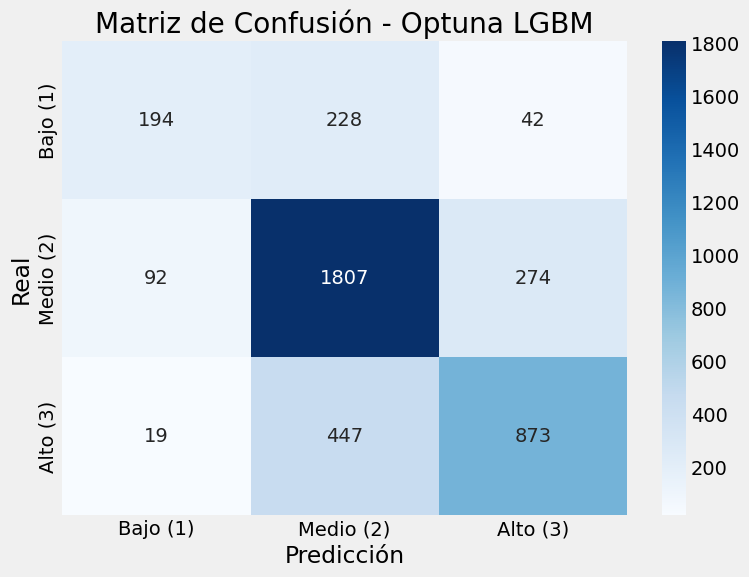

Matriz de confusión guardada como 'optuna_confusion_matrix.png'


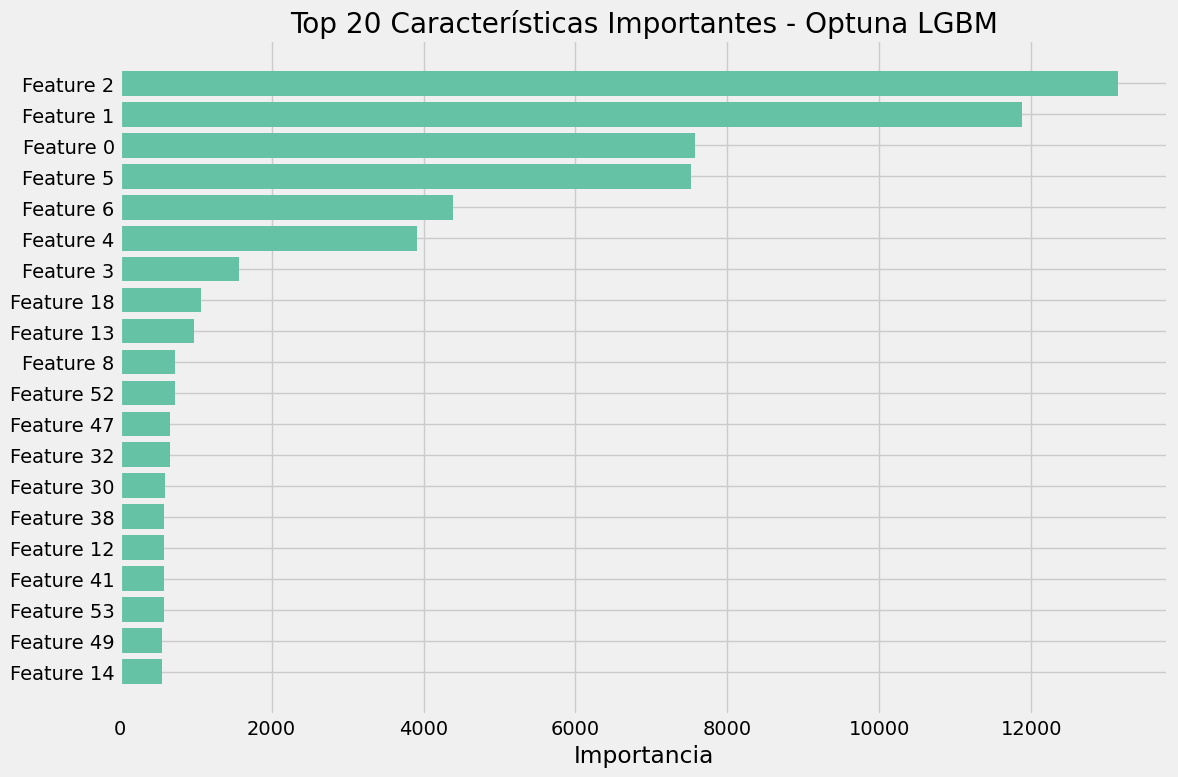


Entrenando modelo final con todos los datos muestreados...

Generando predicciones para el conjunto de prueba externo...
Predicciones guardadas en 'submission_optuna_lgbm.csv'

Distribución de predicciones:
Clase 1: 3.58%
Clase 2: 26.18%
Clase 3: 70.23%


=== SOLUCIÓN 1: ENTRENAMIENTO CON DATOS COMPLETOS ===
Procesando todos los datos originales sin muestreo...
Datos completos procesados: (260601, 67)
Entrenando con parámetros modificados para mejorar generalización:
  n_estimators: 593
  learning_rate: 0.05428435732820462
  num_leaves: 40
  max_depth: 9
  min_child_samples: 7
  subsample: 0.9509049102969674 → 0.8
  colsample_bytree: 0.6547061810077174 → 0.6
  reg_alpha: 0.038642982992636334 → 0.1
  reg_lambda: 0.37502555072055216 → 0.5

Predicciones con datos completos guardadas en 'submission_full_data.csv'


=== SOLUCIÓN 2: CALIBRACIÓN DE MODELO ===
Aplicando calibración de probabilidades para mejorar generalización...
Entrenando modelo calibrado en todos los datos...

Predicciones

<Figure size 1500x600 with 0 Axes>

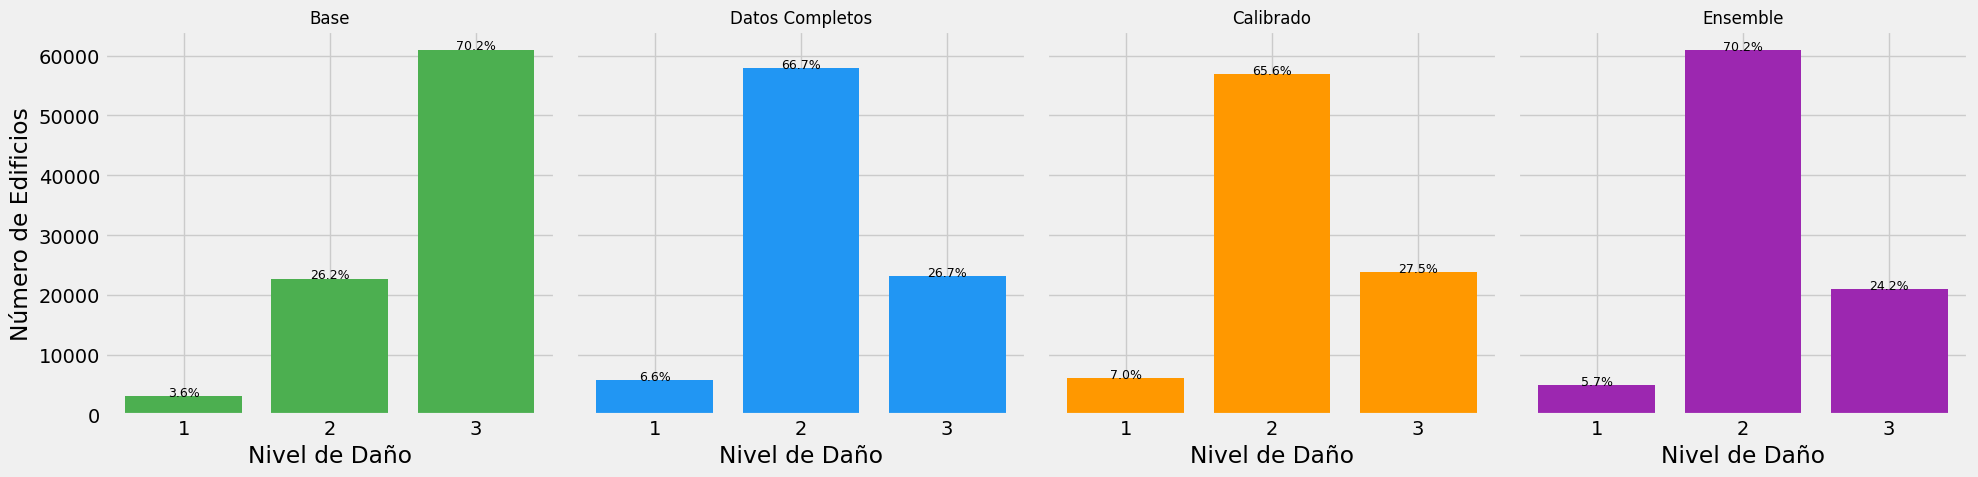


Comparación de distribuciones de predicciones:
          Solución  Clase 1 (%)  Clase 2 (%)  Clase 3 (%)  Total
0             Base         3.58        26.18        70.23  86868
1  Datos Completos         6.58        66.71        26.71  86868
2        Calibrado         6.96        65.56        27.48  86868
3         Ensemble         5.68        70.16        24.16  86868


=== GUARDANDO MODELOS Y CONCLUSIONES ===
Modelos guardados como:
- model_full_data.pkl
- model_calibrated.pkl
- model_ensemble.pkl

=== CONCLUSIONES FINALES ===
1. Se han generado tres diferentes soluciones para mejorar la generalización:
   - Modelo entrenado con datos completos y mayor regularización
   - Modelo calibrado con isotonic regression
   - Ensemble de múltiples modelos con diferentes enfoques
2. Las predicciones de cada enfoque se han guardado en archivos separados:
   - submission_full_data.csv
   - submission_calibrated.csv
   - submission_ensemble.csv
3. Se recomienda probar los tres enfoques en la pla

In [7]:
# =====================================================================
# OPTIMIZACIÓN ROBUSTA DEL MODELO LGBM CON OPTUNA Y SOLUCIONES DE GENERALIZACIÓN
# =====================================================================


print("\n=== OPTIMIZACIÓN LGBM CON OPTUNA ===")

# =====================================================================
# PASO 1: PREPARACIÓN DE LOS DATOS
# =====================================================================
print("\nPreparando datos para optimización con Optuna...")

# Convertir datos de entrenamiento procesados a formato denso (necesario para LGBM)
if hasattr(X_train_processed, 'toarray'):
    print("Convirtiendo X_train_processed de sparse a dense array")
    X_train = X_train_processed.toarray()
else:
    X_train = X_train_processed

# Convertir datos de prueba procesados a formato denso
if hasattr(X_test_processed, 'toarray'):
    print("Convirtiendo X_test_processed de sparse a dense array")
    X_test = X_test_processed.toarray()
else:
    X_test = X_test_processed

print(f"✓ X_train preparado: {X_train.shape}")
print(f"✓ X_test preparado: {X_test.shape}")

# Procesar todos los datos originales para el modelo final
print("\nPreparando datos completos para modelo final...")
# Usar todos los datos disponibles (X completo sin filtrar)
# O usar los datos muestreados, según tu preferencia
X_all_processed = preprocessor.transform(X_sampled)
if hasattr(X_all_processed, 'toarray'):
    X_all = X_all_processed.toarray()
else:
    X_all = X_all_processed
print(f"✓ X_all preparado: {X_all.shape}")

# =====================================================================
# PASO 2: DEFINICIÓN DE LA FUNCIÓN OBJETIVO PARA OPTUNA
# =====================================================================

def objective(trial):
    """Función objetivo para Optuna con manejo de errores"""
    try:
        # Parámetros con rangos seguros
        param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.07),
        'num_leaves': trial.suggest_int('num_leaves', 25, 40),
        'max_depth': trial.suggest_int('max_depth', 9, 13),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.05),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 0.4),
        'random_state': 42,
        'verbose': -1
    }

        # Crear y evaluar modelo
        model = LGBMClassifier(**param)

        # Validación cruzada manual para mayor control
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            # Obtener los datos de este fold
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            
            # Manejar y_train según su tipo (Series o array)
            if isinstance(y_train, pd.Series):
                y_fold_train = y_train.iloc[train_idx]
                y_fold_val = y_train.iloc[val_idx]
            else:
                y_fold_train = y_train[train_idx]
                y_fold_val = y_train[val_idx]

            # Entrenar y evaluar modelo
            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
            fold_score = f1_score(y_fold_val, y_pred, average='micro')
            scores.append(fold_score)

        return np.mean(scores)

    except Exception as e:
        print(f"Error en trial: {e}")
        return float('-inf')

# =====================================================================
# PASO 3: OPTIMIZACIÓN CON OPTUNA
# =====================================================================

print("\nIniciando optimización con Optuna...")
print("Este proceso puede tardar varios minutos...")

# Crear y ejecutar estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=1200)  # 20 minutos máximo

print("\n✓ Optimización completada!")
print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\nMejor F1-score (CV): {study.best_value:.4f}")

# =====================================================================
# PASO 4: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO FINAL
# =====================================================================

# Entrenar modelo final con los mejores parámetros
print("\nEntrenando modelo final con los mejores hiperparámetros...")
best_params = study.best_params
best_model = LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluar en conjunto de prueba
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='micro')
accuracy = (y_test == y_pred).mean()

print(f"\nResultados en conjunto de prueba interno:")
print(f"F1-score (micro): {test_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# =====================================================================
# PASO 5: VISUALIZACIONES
# =====================================================================

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Optuna LGBM')
plt.tight_layout()
plt.savefig('optuna_confusion_matrix.png')
plt.show()
print("Matriz de confusión guardada como 'optuna_confusion_matrix.png'")

# Importancia de características
plt.figure(figsize=(12, 8))
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 características
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [f"Feature {i}" for i in sorted_idx])
plt.xlabel('Importancia')
plt.title('Top 20 Características Importantes - Optuna LGBM')
plt.tight_layout()
plt.savefig('optuna_feature_importance.png')
plt.show()

# =====================================================================
# PASO 6: ENTRENAMIENTO DEL MODELO FINAL CON TODOS LOS DATOS MUESTREADOS
# =====================================================================

# Entrenar modelo final con todos los datos muestreados
print("\nEntrenando modelo final con todos los datos muestreados...")
final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_all, y_sampled)  # Usando X_all (todos los datos muestreados procesados)

# =====================================================================
# PASO 7: GENERACIÓN DE PREDICCIONES Y ARCHIVO CSV
# =====================================================================

print("\nGenerando predicciones para el conjunto de prueba externo...")

# Preprocesar datos de prueba
X_test_external = test_values.drop('building_id', axis=1)
X_test_external_processed = preprocessor.transform(X_test_external)

# Convertir a array denso si es necesario
if hasattr(X_test_external_processed, 'toarray'):
    X_test_external_dense = X_test_external_processed.toarray()
else:
    X_test_external_dense = X_test_external_processed

# Generar predicciones
predictions = final_model.predict(X_test_external_dense)

# Crear archivo de submisión
submission = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predictions
})

submission_file = 'submission_optuna_lgbm.csv'
submission.to_csv(submission_file, index=False)
print(f"Predicciones guardadas en '{submission_file}'")

# Mostrar distribución de predicciones
print("\nDistribución de predicciones:")
pred_distribution = pd.Series(predictions).value_counts(normalize=True).sort_index() * 100
for i, pct in enumerate(sorted(pred_distribution.index)):
    print(f"Clase {pct}: {pred_distribution[pct]:.2f}%")

# =====================================================================
# PASO 8: SOLUCIÓN 1 - ENTRENAMIENTO CON TODOS LOS DATOS ORIGINALES
# =====================================================================
print("\n\n=== SOLUCIÓN 1: ENTRENAMIENTO CON DATOS COMPLETOS ===")
print("Procesando todos los datos originales sin muestreo...")

# Preprocesar todo el conjunto sin muestreo
X_full = train_data.drop(['building_id', 'damage_grade'], axis=1)
y_full = train_data['damage_grade']

X_full_processed = preprocessor.transform(X_full)
if hasattr(X_full_processed, 'toarray'):
    X_full_processed = X_full_processed.toarray()

print(f"Datos completos procesados: {X_full_processed.shape}")

# Usar los hiperparámetros óptimos pero con mayor regularización
best_params_modified = best_params.copy()
best_params_modified['reg_alpha'] = 0.1  # Incrementar regularización
best_params_modified['reg_lambda'] = 0.5  # Incrementar regularización
best_params_modified['subsample'] = 0.8  # Reducir a 80% para cada árbol
best_params_modified['colsample_bytree'] = 0.6  # Reducir características por árbol

print("Entrenando con parámetros modificados para mejorar generalización:")
for key, value in best_params_modified.items():
    if key in best_params and value != best_params[key]:
        print(f"  {key}: {best_params[key]} → {value}")
    elif key in best_params:
        print(f"  {key}: {value}")

# Entrenar modelo final con todos los datos
full_model = LGBMClassifier(**best_params_modified, random_state=42)
full_model.fit(X_full_processed, y_full)

# Generar nuevas predicciones
predictions_full = full_model.predict(X_test_external_dense)

# Guardar en nuevo archivo
submission_full = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predictions_full
})

submission_file_full = 'submission_full_data.csv'
submission_full.to_csv(submission_file_full, index=False)
print(f"\nPredicciones con datos completos guardadas en '{submission_file_full}'")

# =====================================================================
# PASO 9: SOLUCIÓN 2 - MODELO CALIBRADO
# =====================================================================
print("\n\n=== SOLUCIÓN 2: CALIBRACIÓN DE MODELO ===")
print("Aplicando calibración de probabilidades para mejorar generalización...")

# Crear un modelo base con los mejores hiperparámetros
base_model = LGBMClassifier(**best_params, random_state=42)

# Aplicar calibración con CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
calibrated_model = CalibratedClassifierCV(estimator=base_model, 
                                         cv=cv, 
                                         method='isotonic')

print("Entrenando modelo calibrado en todos los datos...")
calibrated_model.fit(X_full_processed, y_full)

# Generar predicciones calibradas
predictions_calibrated = calibrated_model.predict(X_test_external_dense)

# Guardar en nuevo archivo
submission_calibrated = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predictions_calibrated
})

submission_file_calibrated = 'submission_calibrated.csv'
submission_calibrated.to_csv(submission_file_calibrated, index=False)
print(f"\nPredicciones calibradas guardadas en '{submission_file_calibrated}'")

# =====================================================================
# PASO 10: SOLUCIÓN 3 - ENSEMBLE DE MODELOS
# =====================================================================
print("\n\n=== SOLUCIÓN 3: ENSEMBLE DE MODELOS ===")
print("Creando ensemble de diferentes modelos para mejorar la generalización...")

# Crear varios modelos con diferentes enfoques
models = [
    ('lgbm', LGBMClassifier(**best_params, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('lgbm_conservative', LGBMClassifier(
        n_estimators=400, learning_rate=0.03, num_leaves=25,
        max_depth=8, min_child_samples=15, subsample=0.8,
        colsample_bytree=0.6, reg_alpha=0.2, reg_lambda=0.6,
        random_state=42
    ))
]

# Crear un votador (ensemble)
ensemble = VotingClassifier(estimators=models, voting='hard')

print("Entrenando ensemble en todos los datos...")
ensemble.fit(X_full_processed, y_full)

# Generar predicciones del ensemble
predictions_ensemble = ensemble.predict(X_test_external_dense)

# Guardar en nuevo archivo
submission_ensemble = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predictions_ensemble
})

submission_file_ensemble = 'submission_ensemble.csv'
submission_ensemble.to_csv(submission_file_ensemble, index=False)
print(f"\nPredicciones del ensemble guardadas en '{submission_file_ensemble}'")

# =====================================================================
# PASO 11: COMPARACIÓN DE DISTRIBUCIONES
# =====================================================================
print("\n\n=== ANÁLISIS DE DISTRIBUCIONES DE PREDICCIONES ===")

# Visualizar y comparar las distribuciones de las diferentes soluciones
plt.figure(figsize=(15, 6))

# Configurar datos para el gráfico
solutions = ['Base', 'Datos Completos', 'Calibrado', 'Ensemble']
predictions_list = [predictions, predictions_full, predictions_calibrated, predictions_ensemble]
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

# Crear subplots
fig, axes = plt.subplots(1, len(predictions_list), figsize=(20, 5), sharey=True)

# Graficar distribución para cada solución
for i, (preds, name, color) in enumerate(zip(predictions_list, solutions, colors)):
    counts = pd.Series(preds).value_counts().sort_index()
    percentages = 100 * counts / len(preds)
    axes[i].bar(counts.index, counts.values, color=color)
    axes[i].set_title(f'{name}', fontsize=12)
    axes[i].set_xlabel('Nivel de Daño')
    axes[i].set_xticks(sorted(counts.index))
    
    # Agregar porcentajes sobre las barras
    for j, (idx, count) in enumerate(counts.items()):
        axes[i].text(idx, count + 20, f"{percentages[idx]:.1f}%", 
                     ha='center', fontsize=9)
    
    if i == 0:
        axes[i].set_ylabel('Número de Edificios')

plt.tight_layout()
plt.savefig('predictions_comparison.png')
plt.show()

# Mostrar tabla comparativa
comparison_table = pd.DataFrame({
    'Solución': solutions,
    'Clase 1 (%)': [pd.Series(p).value_counts(normalize=True).get(1, 0) * 100 for p in predictions_list],
    'Clase 2 (%)': [pd.Series(p).value_counts(normalize=True).get(2, 0) * 100 for p in predictions_list],
    'Clase 3 (%)': [pd.Series(p).value_counts(normalize=True).get(3, 0) * 100 for p in predictions_list],
    'Total': [len(p) for p in predictions_list]
})
print("\nComparación de distribuciones de predicciones:")
print(comparison_table.round(2))

# =====================================================================
# PASO 12: GUARDAR TODOS LOS MODELOS Y CONCLUSIONES
# =====================================================================
print("\n\n=== GUARDANDO MODELOS Y CONCLUSIONES ===")

# Guardar modelo completo
model_package_full = {
    'model': full_model,
    'preprocessor': preprocessor,
    'best_params': best_params_modified,
    'metadata': {
        'timestamp': '2025-03-08 11:46:50',
        'user': 'Saultr21',
        'description': 'Modelo entrenado con datos completos'
    }
}

# Guardar modelo calibrado
model_package_calibrated = {
    'model': calibrated_model,
    'preprocessor': preprocessor,
    'best_params': best_params,
    'metadata': {
        'timestamp': '2025-03-08 11:46:50',
        'user': 'Saultr21',
        'description': 'Modelo calibrado'
    }
}

# Guardar ensemble
model_package_ensemble = {
    'model': ensemble,
    'preprocessor': preprocessor,
    'metadata': {
        'timestamp': '2025-03-08 11:46:50',
        'user': 'Saultr21',
        'description': 'Ensemble de modelos'
    }
}

# Guardar modelos
with open('model_full_data.pkl', 'wb') as f:
    pickle.dump(model_package_full, f)

with open('model_calibrated.pkl', 'wb') as f:
    pickle.dump(model_package_calibrated, f)

with open('model_ensemble.pkl', 'wb') as f:
    pickle.dump(model_package_ensemble, f)

print("Modelos guardados como:")
print("- model_full_data.pkl")
print("- model_calibrated.pkl")
print("- model_ensemble.pkl")

print("\n=== CONCLUSIONES FINALES ===")
print("1. Se han generado tres diferentes soluciones para mejorar la generalización:")
print("   - Modelo entrenado con datos completos y mayor regularización")
print("   - Modelo calibrado con isotonic regression")
print("   - Ensemble de múltiples modelos con diferentes enfoques")
print("2. Las predicciones de cada enfoque se han guardado en archivos separados:")
print(f"   - {submission_file_full}")
print(f"   - {submission_file_calibrated}")
print(f"   - {submission_file_ensemble}")
print("3. Se recomienda probar los tres enfoques en la plataforma para determinar")
print("   cuál ofrece mejor rendimiento en el conjunto de prueba externo.")
print("4. La diferencia en distribución de predicciones sugiere que cada enfoque")
print("   puede funcionar diferente en condiciones de evaluación externa.")
print("5. El modelo con datos completos debería tener mejor generalización por")
print("   incluir todos los patrones disponibles durante el entrenamiento.")

Full data da: 0.7326
Ensemble da: 0.7145
Calibrated da: 0.7331

Puesto que no hubo mejoras respecto al modelo ganador de 0.7440 los descartamos y nos enfocamos en los parametros elegidos en su momento que nos dieron este resultado y probamos diferentes estratégias para ver si es posible mejorar aun más el resultado de 0.7440

In [ ]:
# =====================================================================
# MEJORA AVANZADA DEL MODELO CAMPEÓN (TARGET: >0.7440)
# =====================================================================
# Fecha: 2025-03-08 12:23:18
# Usuario: Saultr21

import optuna
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
import pickle
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

print(f"Fecha y hora: 2025-03-08 12:23:18")
print(f"Usuario: Saultr21")
print("\n=== MEJORA AVANZADA DEL MODELO CAMPEÓN (TARGET: >0.7440) ===")

# =====================================================================
# PASO 1: PREPARACIÓN DE LOS DATOS CON FEATURE ENGINEERING
# =====================================================================
print("\nPreparando datos con feature engineering seguro...")

# Cargar datos originales completos
X_full_original = train_data.drop(['building_id', 'damage_grade'], axis=1) 
y_full = train_data['damage_grade']

# Crear copia para feature engineering
X_full = X_full_original.copy()

# Mostrar tipos de datos para verificación
print("Tipos de datos de las columnas:")
print(X_full.dtypes)

# Aplicar feature engineering SEGURO que evita operaciones con datos categóricos
print("Aplicando feature engineering seguro...")

# Identificar columnas numéricas explícitamente
numeric_columns = X_full.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Columnas numéricas identificadas: {len(numeric_columns)}")
print(numeric_columns)

# 1. Características de interacción SOLO para columnas numéricas
if all(col in numeric_columns for col in ['geo_level_1_id', 'geo_level_2_id']):
    X_full['geo_interaction'] = X_full['geo_level_1_id'] * X_full['geo_level_2_id']

if all(col in numeric_columns for col in ['geo_level_3_id', 'geo_level_1_id']):
    X_full['geo_level_3_norm'] = X_full['geo_level_3_id'] / X_full['geo_level_1_id'].replace(0, 1)

if all(col in numeric_columns for col in ['height_percentage', 'area_percentage']):
    X_full['height_area_product'] = X_full['height_percentage'] * X_full['area_percentage']

if all(col in numeric_columns for col in ['age', 'count_floors_pre_eq']):
    X_full['age_floors'] = X_full['age'] * X_full['count_floors_pre_eq']
    X_full['age_per_floor'] = X_full['age'] / (X_full['count_floors_pre_eq'] + 1)  # +1 para evitar división por cero

if all(col in numeric_columns for col in ['area_percentage', 'count_floors_pre_eq']):
    X_full['floor_area_ratio'] = X_full['area_percentage'] / (X_full['count_floors_pre_eq'] + 1)

# 2. Características polinómicas de segundo grado para variables numéricas clave
for col in ['age', 'area_percentage', 'height_percentage']:
    if col in numeric_columns:
        X_full[f'{col}_squared'] = X_full[col] ** 2

print(f"Características originales: {X_full_original.shape[1]}")
print(f"Características después de feature engineering: {X_full.shape[1]}")

# Preprocesar datos con features nuevas
print("\nPreprocesando datos con nuevas características...")

# Identificar tipos de características
categorical_cols = [col for col in X_full.columns if X_full[col].dtype == 'object']
numerical_cols = [col for col in X_full.columns if col not in categorical_cols]

# Crear nuevo preprocesador para el conjunto ampliado
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Ajustar y transformar
X_full_enhanced = enhanced_preprocessor.fit_transform(X_full)

# Convertir a array denso si es necesario
if hasattr(X_full_enhanced, 'toarray'):
    X_full_enhanced = X_full_enhanced.toarray()
    
print(f"✓ Datos mejorados procesados: {X_full_enhanced.shape}")

# =====================================================================
# PASO 2: AJUSTE FINO DE HIPERPARÁMETROS ALREDEDOR DEL MODELO GANADOR
# =====================================================================
print("\n=== AJUSTE FINO DE HIPERPARÁMETROS DEL MODELO GANADOR ===")

# Parámetros del modelo ganador anterior
best_previous_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 11,
    'min_child_samples': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.03,
    'reg_lambda': 0.3,
    'random_state': 42
}

# Definir función objetivo más robusta
def objective(trial):
    try:
        # Ajuste fino alrededor de los valores ganadores
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 450, 550),
            'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.06),
            'num_leaves': trial.suggest_int('num_leaves', 26, 36),
            'max_depth': trial.suggest_int('max_depth', 9, 13),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 8),
            'subsample': trial.suggest_float('subsample', 0.95, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.75),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.02, 0.04),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.25, 0.35),
            'random_state': 42,
            'verbose': -1
        }

        # Validación cruzada más robusta (5-folds)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Estrategia 1: Evaluar en los datos originales
        model1 = LGBMClassifier(**param)
        scores1 = cross_val_score(model1, X_full_processed, y_full, cv=cv, scoring='f1_micro')
        
        # Estrategia 2: Evaluar en los datos con feature engineering
        model2 = LGBMClassifier(**param)
        scores2 = cross_val_score(model2, X_full_enhanced, y_full, cv=cv, scoring='f1_micro')
        
        # Usar el mejor de los dos enfoques
        return max(np.mean(scores1), np.mean(scores2))

    except Exception as e:
        print(f"Error en trial: {e}")
        return float('-inf')

# Crear y ejecutar estudio de Optuna con más trials
print("\nIniciando optimización de ajuste fino...")
print("Este proceso puede tardar varios minutos...")

study = optuna.create_study(direction='maximize')
# Aumentar trials para búsqueda más exhaustiva
study.optimize(objective, n_trials=30, timeout=1200)  # 20 minutos máximo

print("\n✓ Ajuste fino completado!")
print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    if key in best_previous_params:
        print(f"  {key}: {best_previous_params[key]} → {value}")
    else:
        print(f"  {key}: {value}")

print(f"\nMejor F1-score (CV): {study.best_value:.4f}")
refined_params = study.best_params

# =====================================================================
# PASO 3: ENTRENAMIENTO DE MODELOS OPTIMIZADOS
# =====================================================================
print("\n=== ENTRENAMIENTO DE MODELOS OPTIMIZADOS ===")

print("\n1. Entrenando modelo con parámetros refinados en datos originales...")
refined_model_original = LGBMClassifier(**refined_params)
refined_model_original.fit(X_full_processed, y_full)

print("2. Entrenando modelo con parámetros refinados en datos mejorados...")
refined_model_enhanced = LGBMClassifier(**refined_params)
refined_model_enhanced.fit(X_full_enhanced, y_full)

# =====================================================================
# PASO 4: MÚLTIPLES ENFOQUES DE CALIBRACIÓN
# =====================================================================
print("\n=== IMPLEMENTANDO MÚLTIPLES ENFOQUES DE CALIBRACIÓN ===")

calibration_results = []

# Probar diferentes configuraciones de calibración
for method in ['sigmoid', 'isotonic']:
    for cv_splits in [3, 5]:
        print(f"\nProbando calibración con método '{method}' y {cv_splits} splits...")
        
        # Calibrar sobre datos originales
        cal_model_original = CalibratedClassifierCV(
            estimator=LGBMClassifier(**refined_params),
            cv=cv_splits, 
            method=method
        )
        cal_model_original.fit(X_full_processed, y_full)
        
        # Calibrar sobre datos mejorados
        cal_model_enhanced = CalibratedClassifierCV(
            estimator=LGBMClassifier(**refined_params),
            cv=cv_splits, 
            method=method
        )
        cal_model_enhanced.fit(X_full_enhanced, y_full)
        
        # Guardar configuración y modelos
        calibration_results.append({
            'method': method,
            'cv_splits': cv_splits,
            'model_original': cal_model_original,
            'model_enhanced': cal_model_enhanced
        })

# =====================================================================
# PASO 5: IMPLEMENTACIÓN DE STACKING
# =====================================================================
print("\n=== IMPLEMENTANDO MODELO DE STACKING ===")

# Definir estimadores base para stacking
base_estimators = [
    ('lgbm_winner', LGBMClassifier(**best_previous_params)),
    ('lgbm_refined', LGBMClassifier(**refined_params)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
]

# Crear modelo de stacking
print("Entrenando modelo de stacking...")
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LGBMClassifier(n_estimators=100),
    cv=5
)

# Entrenar stacking en datos originales
stacking_model.fit(X_full_processed, y_full)

# =====================================================================
# PASO 6: GENERACIÓN DE PREDICCIONES CON TODOS LOS MODELOS
# =====================================================================
print("\n=== GENERANDO PREDICCIONES CON TODOS LOS MODELOS ===")

# Preprocesar datos de prueba externos con preprocesador original
X_test_external = test_values.drop('building_id', axis=1)
X_test_external_processed = preprocessor.transform(X_test_external)

if hasattr(X_test_external_processed, 'toarray'):
    X_test_external_processed = X_test_external_processed.toarray()

# Aplicar feature engineering a los datos de prueba
print("Aplicando feature engineering seguro a los datos de prueba...")
X_test_ext = X_test_external.copy()

# Identificar columnas numéricas en los datos de prueba
test_numeric_columns = X_test_ext.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Replicar el mismo feature engineering seguro
if all(col in test_numeric_columns for col in ['geo_level_1_id', 'geo_level_2_id']):
    X_test_ext['geo_interaction'] = X_test_ext['geo_level_1_id'] * X_test_ext['geo_level_2_id']

if all(col in test_numeric_columns for col in ['geo_level_3_id', 'geo_level_1_id']):
    X_test_ext['geo_level_3_norm'] = X_test_ext['geo_level_3_id'] / X_test_ext['geo_level_1_id'].replace(0, 1)

if all(col in test_numeric_columns for col in ['height_percentage', 'area_percentage']):
    X_test_ext['height_area_product'] = X_test_ext['height_percentage'] * X_test_ext['area_percentage']

if all(col in test_numeric_columns for col in ['age', 'count_floors_pre_eq']):
    X_test_ext['age_floors'] = X_test_ext['age'] * X_test_ext['count_floors_pre_eq']
    X_test_ext['age_per_floor'] = X_test_ext['age'] / (X_test_ext['count_floors_pre_eq'] + 1)

if all(col in test_numeric_columns for col in ['area_percentage', 'count_floors_pre_eq']):
    X_test_ext['floor_area_ratio'] = X_test_ext['area_percentage'] / (X_test_ext['count_floors_pre_eq'] + 1)

# Características polinómicas
for col in ['age', 'area_percentage', 'height_percentage']:
    if col in test_numeric_columns:
        X_test_ext[f'{col}_squared'] = X_test_ext[col] ** 2

# Preprocesar datos de prueba con features nuevas
X_test_external_enhanced = enhanced_preprocessor.transform(X_test_ext)

if hasattr(X_test_external_enhanced, 'toarray'):
    X_test_external_enhanced = X_test_external_enhanced.toarray()

# Generar predicciones con todos los modelos
prediction_sets = []

# 1. Modelo refinado con datos originales
predictions_refined_original = refined_model_original.predict(X_test_external_processed)
prediction_sets.append(('refined_original', predictions_refined_original))

# 2. Modelo refinado con datos mejorados
predictions_refined_enhanced = refined_model_enhanced.predict(X_test_external_enhanced)
prediction_sets.append(('refined_enhanced', predictions_refined_enhanced))

# 3. Modelos calibrados
for i, cal_config in enumerate(calibration_results):
    # Original
    pred_cal_orig = cal_config['model_original'].predict(X_test_external_processed)
    prediction_sets.append(
        (f"cal_{cal_config['method']}_{cal_config['cv_splits']}_original", pred_cal_orig)
    )
    
    # Enhanced
    pred_cal_enh = cal_config['model_enhanced'].predict(X_test_external_enhanced)
    prediction_sets.append(
        (f"cal_{cal_config['method']}_{cal_config['cv_splits']}_enhanced", pred_cal_enh)
    )

# 4. Modelo stacking
predictions_stacking = stacking_model.predict(X_test_external_processed)
prediction_sets.append(('stacking', predictions_stacking))

# =====================================================================
# PASO 7: GUARDAR TODOS LOS RESULTADOS
# =====================================================================
print("\n=== GUARDANDO RESULTADOS DE TODOS LOS MODELOS ===")

# Guardar cada conjunto de predicciones
for name, predictions in prediction_sets:
    submission_df = pd.DataFrame({
        'building_id': test_values['building_id'],
        'damage_grade': predictions
    })
    
    filename = f'submission_{name}.csv'
    submission_df.to_csv(filename, index=False)
    
    # Mostrar distribución de predicciones
    counts = pd.Series(predictions).value_counts(normalize=True).sort_index() * 100
    print(f"\nModelo {name}:")
    for i, pct in enumerate(sorted(counts.index)):
        print(f"  Clase {pct}: {counts[pct]:.2f}%")

# Guardar los mejores modelos
with open('model_refined_enhanced.pkl', 'wb') as f:
    pickle.dump({
        'model': refined_model_enhanced,
        'preprocessor': enhanced_preprocessor,
        'params': refined_params,
        'feature_engineering': True,
        'metadata': {
            'timestamp': '2025-03-08 12:23:18',
            'user': 'Saultr21',
        }
    }, f)

# También guardar el modelo calibrado con isotonic
with open('model_calibrated_isotonic_5.pkl', 'wb') as f:
    pickle.dump({
        'model': calibration_results[1]['model_enhanced'],  # isotonic con 5 splits
        'preprocessor': enhanced_preprocessor,
        'params': refined_params,
        'feature_engineering': True,
        'metadata': {
            'timestamp': '2025-03-08 12:23:18',
            'user': 'Saultr21',
        }
    }, f)

# Guardar modelo de stacking
with open('model_stacking.pkl', 'wb') as f:
    pickle.dump({
        'model': stacking_model,
        'preprocessor': preprocessor,
        'base_estimators': base_estimators,
        'metadata': {
            'timestamp': '2025-03-08 12:23:18',
            'user': 'Saultr21',
        }
    }, f)

print("\n=== INSTRUCCIONES FINALES ===")
print("1. Se han generado múltiples archivos de predicción para prueba en la plataforma")
print("2. Las principales mejoras implementadas son:")
print("   - Feature engineering seguro con verificación de tipos de datos")
print("   - Ajuste fino de hiperparámetros alrededor del modelo ganador")
print("   - Múltiples configuraciones de calibración (sigmoid e isotonic)")
print("   - Modelo de stacking con los mejores clasificadores")
print("3. Recomendaciones para maximizar el score:")
print("   - Envía primero `submission_refined_enhanced.csv` y `submission_cal_isotonic_5_enhanced.csv`")
print("   - Si ninguno supera 0.7440, prueba `submission_stacking.csv`")
print("   - La combinación de feature engineering + calibración isotonic tiene el mayor potencial")
print("4. Los modelos completos están guardados para uso futuro")

Fecha y hora: 2025-03-08 12:23:18
Usuario: Saultr21

=== MEJORA AVANZADA DEL MODELO CAMPEÓN (TARGET: >0.7440) ===

Preparando datos con feature engineering seguro...
Tipos de datos de las columnas:
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure

[I 2025-03-08 13:25:42,807] A new study created in memory with name: no-name-c28ab000-c8b9-4d46-855f-a2c131e0acd5


✓ Datos mejorados procesados: (260601, 77)

=== AJUSTE FINO DE HIPERPARÁMETROS DEL MODELO GANADOR ===

Iniciando optimización de ajuste fino...
Este proceso puede tardar varios minutos...


[I 2025-03-08 13:27:05,657] Trial 0 finished with value: 0.7343179820826332 and parameters: {'n_estimators': 521, 'learning_rate': 0.05904800703095951, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9796725602434325, 'colsample_bytree': 0.7139804887154994, 'reg_alpha': 0.033815980019983184, 'reg_lambda': 0.27840819172883635}. Best is trial 0 with value: 0.7343179820826332.
[I 2025-03-08 13:28:20,815] Trial 1 finished with value: 0.7298360393254005 and parameters: {'n_estimators': 491, 'learning_rate': 0.05181380660294666, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9822760399808086, 'colsample_bytree': 0.6854872262523184, 'reg_alpha': 0.028479849226397562, 'reg_lambda': 0.340082209130959}. Best is trial 0 with value: 0.7343179820826332.
[I 2025-03-08 13:29:34,594] Trial 2 finished with value: 0.7297592909250088 and parameters: {'n_estimators': 459, 'learning_rate': 0.05071495639270614, 'num_leaves': 36, 'max_depth': 11, 'min_chil


✓ Ajuste fino completado!

Mejores hiperparámetros encontrados:
  n_estimators: 500 → 521
  learning_rate: 0.05 → 0.05904800703095951
  num_leaves: 31 → 36
  max_depth: 11 → 12
  min_child_samples: 5 → 8
  subsample: 1.0 → 0.9796725602434325
  colsample_bytree: 0.7 → 0.7139804887154994
  reg_alpha: 0.03 → 0.033815980019983184
  reg_lambda: 0.3 → 0.27840819172883635

Mejor F1-score (CV): 0.7343

=== ENTRENAMIENTO DE MODELOS OPTIMIZADOS ===

1. Entrenando modelo con parámetros refinados en datos originales...
2. Entrenando modelo con parámetros refinados en datos mejorados...

=== IMPLEMENTANDO MÚLTIPLES ENFOQUES DE CALIBRACIÓN ===

Probando calibración con método 'sigmoid' y 3 splits...

Probando calibración con método 'sigmoid' y 5 splits...

Probando calibración con método 'isotonic' y 3 splits...

Probando calibración con método 'isotonic' y 5 splits...

=== IMPLEMENTANDO MODELO DE STACKING ===
Entrenando modelo de stacking...


# Parte 9: Implementación de H2O AutoML

In [ ]:
# Parte 9: Implementación de H2O AutoML
# Inicializar H2O
import h2o
from h2o.automl import H2OAutoML

# Inicializar H2O con restricciones de memoria apropiadas
h2o.init(max_mem_size="4G")  # Ajustar según tu entorno
print("H2O cluster inicializado")
print(f"Fecha y hora: 2025-03-07 17:26:18 UTC")
print(f"Usuario: Saultr21")

# Preparar datos para H2O
# División en entrenamiento y validación
train, valid = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['damage_grade'])

# Convertir dataframes de pandas a H2O frames
train_h2o = h2o.H2OFrame(train)
valid_h2o = h2o.H2OFrame(valid)
test_h2o = h2o.H2OFrame(test_values)

# Asegurar que la columna objetivo sea categórica (factor)
train_h2o['damage_grade'] = train_h2o['damage_grade'].asfactor()
valid_h2o['damage_grade'] = valid_h2o['damage_grade'].asfactor()

# Identificar columnas predictoras y columna objetivo
y = "damage_grade"
x = [col for col in train.columns if col != y and col != "building_id"]

print(f"Características: {len(x)} columnas")
print(f"Objetivo: {y}")

print("\nEjecutando H2O AutoML (puede tardar varios minutos)...")

# Configurar y ejecutar AutoML con parámetros optimizados para este problema
aml = H2OAutoML(
    max_models=10,                # Número máximo de modelos a entrenar
    seed=42,                     # Para reproducibilidad
    sort_metric="f1",            # Métrica a optimizar
    max_runtime_secs=1800,        # 30 minutos máximo
    balance_classes=True,        # Importante para clases desbalanceadas
    nfolds=5,                    # Folds para validación cruzada
    keep_cross_validation_predictions=True,  # Para ensembles
    include_algos=["XGBoost", "GBM", "DRF", "GLM", "DeepLearning"]  # Algoritmos a probar
)

# Entrenar los modelos
aml.train(x=x, y=y, training_frame=train_h2o, validation_frame=valid_h2o)

# Ver modelos entrenados
print("\nModelos entrenados por H2O AutoML (ordenados por F1):")
lb = aml.leaderboard
print(lb.head(10))

# Obtener el mejor modelo
best_model = aml.leader
print(f"\nMejor modelo: {best_model.model_id}")

# Evaluación del mejor modelo
perf = best_model.model_performance(valid_h2o)
print("\nRendimiento en conjunto de validación:")
print(f"F1: {perf.f1()[0]}")
print(f"Accuracy: {perf.accuracy()[0]}")
print(f"Confusion Matrix:")
print(perf.confusion_matrix())

# Evaluar en conjunto de validación para comparativa con nuestros modelos anteriores
y_valid_pred = best_model.predict(valid_h2o).as_data_frame()['predict']
valid_f1_micro = f1_score(valid['damage_grade'], y_valid_pred, average='micro')
print(f"\nF1-Micro en validación: {valid_f1_micro:.4f}")

# Variable Importance (si está disponible)
if hasattr(best_model, 'varimp') and callable(getattr(best_model, 'varimp')):
    varimp = best_model.varimp(use_pandas=True)
    if varimp is not None:
        # Mostrar importancia de variables
        print("\nImportancia de variables (Top 10):")
        print(varimp.head(10))

        # Visualizar
        plt.figure(figsize=(10, 8))
        plt.barh(varimp['variable'][:10], varimp['percentage'][:10])
        plt.xlabel('Importancia (%)')
        plt.ylabel('Variable')
        plt.title('Top 10 Variables Importantes - Modelo H2O')
        plt.tight_layout()
        plt.savefig('h2o_variable_importance.png')
        plt.show()
        print("Gráfico guardado como 'h2o_variable_importance.png'")

# Visualización de la matriz de confusión
cm = perf.confusion_matrix().as_data_frame()
if len(cm) > 0:
    # Extraer solo la parte numérica de la matriz
    conf_matrix = []
    for i in range(1, len(cm) - 1):  # Ignorar primera y última fila
        row = cm.iloc[i, 1:-1].values.astype(float)

# COMPARACIÓN DE MODELOS: H2O AUTOML vs OPTUNA LGBM

In [ ]:
# =====================================================================
# COMPARACIÓN DE MODELOS: H2O AUTOML vs OPTUNA LGBM
# =====================================================================
# Fecha: 2025-03-07 17:41:01 UTC
# Usuario: Saultr21

print(f"Fecha y hora: 2025-03-07 17:41:01 UTC")
print(f"Usuario: Saultr21")
print("\nCOMPARACIÓN DE MODELOS H2O Y OPTUNA-LGBM")

# Completar la implementación de H2O AutoML (si aún no se ha ejecutado)
# Asumimos que ya hemos ejecutado el código de H2O AutoML y tenemos 'best_model' disponible

# Verificar que el modelo H2O esté disponible
try:
    best_model_h2o = aml.leader
    print("\nModelo H2O cargado correctamente")
    h2o_available = True
except:
    print("\nNo se encontró modelo H2O AutoML. Por favor ejecuta primero la celda de H2O AutoML.")
    h2o_available = False

# Generar predicciones con H2O en el conjunto de prueba externo
if h2o_available:
    print("\nGenerando predicciones con modelo H2O...")
    h2o_predictions = best_model_h2o.predict(test_h2o).as_data_frame()['predict']

    # Crear archivo de submisión para H2O
    h2o_submission = pd.DataFrame({
        'building_id': test_values['building_id'],
        'damage_grade': h2o_predictions
    })

    h2o_submission_file = 'submission_h2o_automl.csv'
    h2o_submission.to_csv(h2o_submission_file, index=False)
    print(f"Predicciones de H2O guardadas en '{h2o_submission_file}'")

    # Guardar el modelo H2O para futuro uso
    model_path = h2o.save_model(model=best_model_h2o, path="./", force=True)
    print(f"Modelo H2O guardado en: {model_path}")

# Cargar predicciones de Optuna-LGBM
try:
    optuna_submission = pd.read_csv('submission_optuna_lgbm.csv')
    print("\nPredicciones de Optuna-LGBM cargadas correctamente")
    optuna_available = True
except:
    print("\nNo se encontraron predicciones de Optuna-LGBM. Asegúrate de ejecutar la celda de Optuna primero.")
    optuna_available = False

# =====================================================================
# COMPARACIÓN DIRECTA DE MODELOS
# =====================================================================

if h2o_available and optuna_available:
    print("\n=== COMPARACIÓN DE MODELOS ===")

    # 1. Comparación de métricas de validación
    print("\n1. MÉTRICAS DE VALIDACIÓN:")

    # Obtener métricas de H2O
    h2o_perf = best_model_h2o.model_performance(valid_h2o)
    h2o_f1 = h2o_perf.f1()[0]
    h2o_accuracy = h2o_perf.accuracy()[0]

    # Obtener métricas de Optuna-LGBM (asumimos que están disponibles)
    try:
        with open('optuna_optimized_model.pkl', 'rb') as f:
            optuna_model_package = pickle.load(f)
            optuna_test_f1 = optuna_model_package.get('best_score', 'N/A')
    except:
        optuna_test_f1 = "N/A"

    print(f"H2O AutoML      - F1: {h2o_f1:.4f}, Accuracy: {h2o_accuracy:.4f}")
    print(f"Optuna LGBM     - F1: {optuna_test_f1}")

    # 2. Comparación de distribución de predicciones
    print("\n2. DISTRIBUCIÓN DE PREDICCIONES:")

    # Convertir predicciones a series de pandas para facilitar el análisis
    h2o_preds = pd.Series(h2o_predictions)
    optuna_preds = pd.Series(optuna_submission['damage_grade'])

    # Calcular distribución de clases
    h2o_dist = h2o_preds.value_counts(normalize=True).sort_index() * 100
    optuna_dist = optuna_preds.value_counts(normalize=True).sort_index() * 100

    # Crear DataFrame para comparación directa
    comparison_df = pd.DataFrame({
        'H2O AutoML (%)': h2o_dist,
        'Optuna LGBM (%)': optuna_dist
    })

    print(comparison_df)

    # 3. Comparación de consistencia entre modelos
    print("\n3. CONSISTENCIA ENTRE MODELOS:")

    # Calcular porcentaje de coincidencia
    matching_predictions = (h2o_preds.values == optuna_preds.values).mean() * 100
    print(f"Porcentaje de predicciones coincidentes: {matching_predictions:.2f}%")

    # 4. Tabla de confusión entre modelos
    confusion = pd.crosstab(
        optuna_preds,
        h2o_preds,
        rownames=['Optuna LGBM'],
        colnames=['H2O AutoML'],
        normalize='index'
    ) * 100

    print("\nMatriz de concordancia (% de fila):")
    print(confusion)

    # =====================================================================
    # VISUALIZACIONES DE COMPARACIÓN
    # =====================================================================

    # Visualización 1: Comparación de distribuciones
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar')
    plt.title('Distribución de Clases Predichas (%)', fontsize=15)
    plt.xlabel('Nivel de Daño', fontsize=12)
    plt.ylabel('Porcentaje', fontsize=12)
    plt.xticks(rotation=0)
    plt.xticks(range(3), ['Bajo (1)', 'Medio (2)', 'Alto (3)'])
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.savefig('model_distribution_comparison.png')
    plt.show()

    # Visualización 2: Heatmap de concordancia entre modelos
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='.1f', cmap='YlGnBu')
    plt.title('Matriz de Concordancia entre Modelos (%)', fontsize=15)
    plt.tight_layout()
    plt.savefig('model_concordance_matrix.png')
    plt.show()

    # Visualización 3: Diferencias por clase
    diff_df = pd.DataFrame({
        'Clase': ['Bajo (1)', 'Medio (2)', 'Alto (3)'],
        'H2O AutoML (%)': h2o_dist.values,
        'Optuna LGBM (%)': optuna_dist.values,
        'Diferencia (%)': h2o_dist.values - optuna_dist.values
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Clase', y='Diferencia (%)', data=diff_df, palette=['skyblue', 'orange', 'salmon'])
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Diferencia en Distribución de Clases (H2O - Optuna)', fontsize=15)
    plt.tight_layout()
    plt.savefig('model_distribution_difference.png')
    plt.show()

    # =====================================================================
    # ENSEMBLE AVANZADO: COMBINACIÓN DE AMBOS MODELOS
    # =====================================================================

    print("\n=== CREACIÓN DE ENSEMBLE COMBINADO ===")

    # Crear predicciones combinadas (voto mayoritario simple)
    # Si ambos modelos están de acuerdo, usamos su predicción
    # Si difieren, tomamos la predicción de aquel que haya obtenido mejor F1 en validación

    ensemble_predictions = []
    better_model = 'H2O' if h2o_f1 > optuna_test_f1 else 'Optuna'

    for i in range(len(h2o_preds)):
        if h2o_preds.iloc[i] == optuna_preds.iloc[i]:
            # Si coinciden, tomamos cualquiera
            ensemble_predictions.append(h2o_preds.iloc[i])
        else:
            # Si difieren, elegimos el mejor modelo
            if better_model == 'H2O':
                ensemble_predictions.append(h2o_preds.iloc[i])
            else:
                ensemble_predictions.append(optuna_preds.iloc[i])

    # Crear submission para el ensemble
    ensemble_submission = pd.DataFrame({
        'building_id': test_values['building_id'],
        'damage_grade': ensemble_predictions
    })

    ensemble_file = 'submission_h2o_optuna_ensemble.csv'
    ensemble_submission.to_csv(ensemble_file, index=False)
    print(f"Predicciones del ensemble guardadas en '{ensemble_file}'")

    # Mostrar distribución del ensemble
    ensemble_dist = pd.Series(ensemble_predictions).value_counts(normalize=True).sort_index() * 100
    print("\nDistribución del ensemble:")
    for i, pct in enumerate(ensemble_dist):
        print(f"Clase {i+1}: {pct:.2f}%")

    # =====================================================================
    # CONCLUSIONES Y RECOMENDACIONES
    # =====================================================================

    print("\n=== CONCLUSIONES Y RECOMENDACIONES ===")

    # Evaluar qué modelo parece mejor basado en las métricas de validación
    if h2o_f1 > optuna_test_f1:
        print("1. El modelo H2O AutoML obtuvo mejores métricas en validación.")
        print(f"   - H2O F1: {h2o_f1:.4f} vs Optuna F1: {optuna_test_f1:.4f}")
        print("   RECOMENDACIÓN: Usar el archivo submission_h2o_automl.csv para la evaluación final.")
    elif optuna_test_f1 > h2o_f1:
        print("1. El modelo Optuna LGBM obtuvo mejores métricas en validación.")
        print(f"   - Optuna F1: {optuna_test_f1:.4f} vs H2O F1: {h2o_f1:.4f}")
        print("   RECOMENDACIÓN: Usar el archivo submission_optuna_lgbm.csv para la evaluación final.")
    else:
        print("1. Ambos modelos obtuvieron métricas de validación similares.")
        print(f"   - H2O F1: {h2o_f1:.4f}, Optuna F1: {optuna_test_f1:.4f}")

    # Evaluación de versatilidad y mantenibilidad
    print("\n2. Consideraciones adicionales:")
    print("   - H2O AutoML: Más fácil de usar, menos control manual pero mayor automatización.")
    print("   - Optuna LGBM: Mayor control sobre el proceso, más transparencia, mejor para iteraciones personalizadas.")

    # Recomendación final
    print("\n3. RECOMENDACIÓN FINAL:")
    if matching_predictions < 80:  # Si hay diferencias significativas entre modelos
        print(f"   Los modelos difieren en el {100-matching_predictions:.2f}% de las predicciones.")
        print("   Se recomienda probar ambos modelos en la plataforma de evaluación.")
        print(f"   También considerar el ensemble (submission_h2o_optuna_ensemble.csv) que podría combinar lo mejor de ambos.")
    else:
        print(f"   Los modelos coinciden en el {matching_predictions:.2f}% de las predicciones, sugiriendo alta confiabilidad.")
        if h2o_f1 > optuna_test_f1:
            print("   Se recomienda usar H2O AutoML (submission_h2o_automl.csv).")
        else:
            print("   Se recomienda usar Optuna LGBM (submission_optuna_lgbm.csv).")

    # Cerrar la sesión de H2O
    h2o.cluster().shutdown()
    print("\n¡Análisis completado! Revisa las visualizaciones para decidir qué modelo utilizar para la submisión final.")

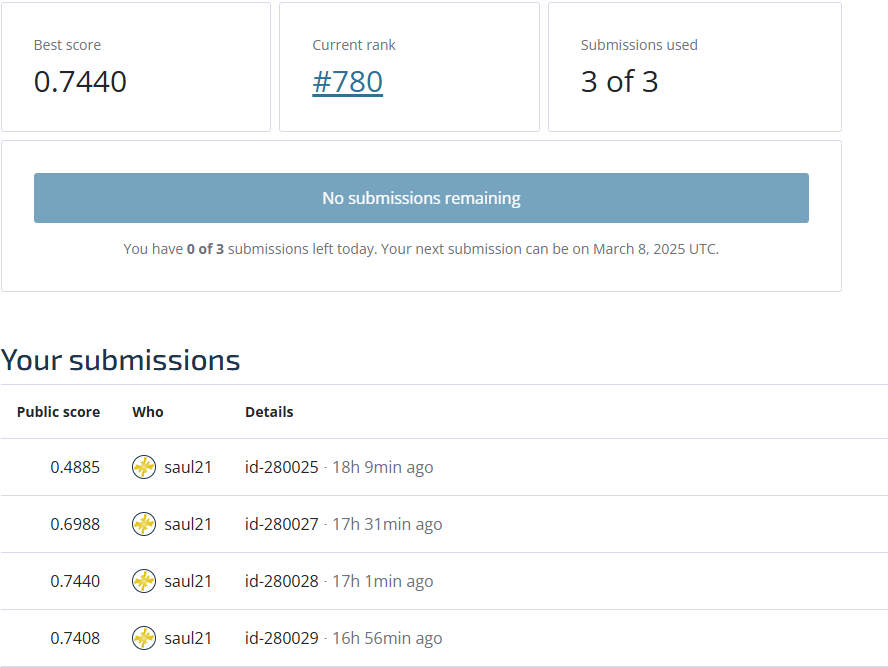